### Instalar bibliotecas

In [1]:
# Instalar bibliotecas ( necessário)
!pip install mlflow evidently scikit-learn pandas numpy matplotlib seaborn papermill

# Importar pacotes principais
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from evidently.report import Report
from evidently.metrics import DataDriftTable
import pickle



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


 Garantir que o ambiente está pronto para rodar os modelos.

### Configurar MLflow para rastreamento de experimentos

In [2]:
# Importando o MLflow
import mlflow
import mlflow.sklearn
import os

# Definindo um novo diretório para armazenar os logs dos experimentos
caminho_logs = "E:\Mestrado UFCG\Semestre 2024.2\Dados\MLOps dropout\EXperimentos_MLflow"

# Criando o diretório se ele não existir
os.makedirs(caminho_logs, exist_ok=True)

# Configurando o MLflow para armazenar logs nesse diretório
mlflow.set_tracking_uri(f"file:///{caminho_logs}")

# Criando um novo experimento (se já existir, ele usa o existente)
mlflow.set_experiment("Evasao_UFCG")

# Exibir a configuração para garantir que está correto
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

Tracking URI: file:///E:\Mestrado UFCG\Semestre 2024.2\Dados\MLOps dropout\EXperimentos_MLflow


### Carregar os dados as tabelas relevantes

In [3]:
import pandas as pd
import os
import mlflow

# Definindo caminhos
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"
tables = ["alunos", "tabela_motivo_evasao", "tabela_dados_ingresso", "tabela_dados_pessoais", "matriculas"]

# Iniciar Experimento MLflow
mlflow.set_experiment("Carregamento de Dados UFCG")

with mlflow.start_run():
    # Log do início do carregamento usando métrica em vez de parâmetro fixo
    mlflow.log_metric("status_iniciando", 1)

    dados = {}
    
    for table in tables:
        caminho = os.path.join(caminho_base, f"{table}.csv")
        try:
            # Detectar delimitador correto
            with open(caminho, "r", encoding="utf-8") as f:
                primeira_linha = f.readline()
                if ";" in primeira_linha:
                    delimitador = ";"
                elif "," in primeira_linha:
                    delimitador = ","
                elif "\t" in primeira_linha:
                    delimitador = "\t"
                else:
                    delimitador = ","  # Padrão caso não detecte

            # Carregar CSV com delimitador correto
            df = pd.read_csv(caminho, delimiter=delimitador, encoding="utf-8")
            
            # Verifica se carregou corretamente
            if df.shape[1] == 1:
                print(f" Atenção: {table} foi carregada com apenas 1 coluna! Pode haver erro no delimitador.")
            
            dados[table] = df
            print(f"{table} carregada com sucesso! ({df.shape[0]} linhas, {df.shape[1]} colunas)")
        except Exception as e:
            print(f"Erro ao carregar {table}: {e}")
            mlflow.log_param(f"erro_{table}", str(e))  # Log do erro no MLflow

    # Usar métrica ao invés de parâmetro para evitar erro no MLflow
    mlflow.log_metric("status_carregamento_finalizado", 1)

    print(" Carregamento finalizado.")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

alunos carregada com sucesso! (3761 linhas, 22 colunas)
tabela_motivo_evasao carregada com sucesso! (3761 linhas, 2 colunas)
tabela_dados_ingresso carregada com sucesso! (3761 linhas, 4 colunas)
tabela_dados_pessoais carregada com sucesso! (3761 linhas, 5 colunas)
matriculas carregada com sucesso! (182660 linhas, 10 colunas)
 Carregamento finalizado.


### Pré-processamento

###  Verificar as primeiras linhas das tabelas

In [4]:
# Explorando as tabelas carregadas
for nome_tabela, df in dados.items():
    print(f"\n Explorando a tabela: {nome_tabela}")
    print(df.info())  # Estrutura geral do DataFrame
    print(df.head())  # Primeiras linhas para visualizar os dados
    print("-" * 80)



 Explorando a tabela: alunos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MATRICULA                   3761 non-null   int64  
 1   ID_CIDADAO                  3743 non-null   float64
 2   NOME                        3761 non-null   object 
 3   IDADE                       3761 non-null   int64  
 4   E-MAIL                      3263 non-null   object 
 5   GENERO                      3761 non-null   object 
 6   ESTADO_CIVIL_ALUNOS         3761 non-null   object 
 7   NACIONALIDADE               3761 non-null   object 
 8   LOCAL_NASCIMENTO            3460 non-null   object 
 9   ESTADO                      3761 non-null   object 
 10  TERMO_ESTADO                3034 non-null   float64
 11  RAZAO_INATIVIDADE           3761 non-null   object 
 12  TIPO_ADMISSAO               3761 non-null   object 
 13  TER

### Verificação de Qualidade dos Dados

In [5]:
# Analisando valores nulos, tipos de dados e estatísticas básicas
for nome_tabela, df in dados.items():
    print(f"\n Analisando a tabela: {nome_tabela}")
    
    # Tipos de dados
    print("\n Tipos de dados:")
    print(df.dtypes)
    
    # Contagem de valores nulos
    print("\n Valores nulos por coluna:")
    print(df.isnull().sum())
    
    # Estatísticas básicas
    print("\n Estatísticas descritivas:")
    print(df.describe(include="all"))  # Inclui colunas numéricas e categóricas
    
    print("-" * 100)



 Analisando a tabela: alunos

 Tipos de dados:
MATRICULA                       int64
ID_CIDADAO                    float64
NOME                           object
IDADE                           int64
E-MAIL                         object
GENERO                         object
ESTADO_CIVIL_ALUNOS            object
NACIONALIDADE                  object
LOCAL_NASCIMENTO               object
ESTADO                         object
TERMO_ESTADO                  float64
RAZAO_INATIVIDADE              object
TIPO_ADMISSAO                  object
TERMO_ADMISSAO                float64
POLITICA_AFIRMATIVA            object
TIPO_ENSINO_MEDIO              object
ANO_FORMATURA_ENSINO_MEDIO    float64
CODIGO_CURSO                    int64
CODIGO_CURRICULAR               int64
 ALUNOS_ATIVOS                   bool
EX_ALUNOS                        bool
ALUNOS_INATIVOS                  bool
dtype: object

 Valores nulos por coluna:
MATRICULA                        0
ID_CIDADAO                      18
NOME

In [6]:
# Verificando a quantidade de valores nulos por tabela
for nome_tabela, df in dados.items():
    print(f"\n {nome_tabela} - Valores nulos por coluna:")
    print(df.isnull().sum())
    print("-" * 50)



 alunos - Valores nulos por coluna:
MATRICULA                        0
ID_CIDADAO                      18
NOME                             0
IDADE                            0
E-MAIL                         498
GENERO                           0
ESTADO_CIVIL_ALUNOS              0
NACIONALIDADE                    0
LOCAL_NASCIMENTO               301
ESTADO                           0
TERMO_ESTADO                   727
RAZAO_INATIVIDADE                0
TIPO_ADMISSAO                    0
TERMO_ADMISSAO                   0
POLITICA_AFIRMATIVA              0
TIPO_ENSINO_MEDIO                0
ANO_FORMATURA_ENSINO_MEDIO    1099
CODIGO_CURSO                     0
CODIGO_CURRICULAR                0
 ALUNOS_ATIVOS                   0
EX_ALUNOS                        0
ALUNOS_INATIVOS                  0
dtype: int64
--------------------------------------------------

 tabela_motivo_evasao - Valores nulos por coluna:
MATRICULA                        0
RAZAO_DE_INATIVIDADE_DE_ALUNO    0
dtype: i

### Identificar colunas com valores nulos

In [7]:
# Verificando e exibindo apenas as colunas com valores nulos por tabela
for nome_tabela, df in dados.items():
    colunas_com_nulos = df.columns[df.isna().sum() > 0]  # Seleciona apenas as colunas com valores nulos
    if len(colunas_com_nulos) > 0:  # Verifica se há colunas com nulos antes de exibir
        print(f"\n {nome_tabela} - Variáveis com valores ausentes:")
        print(df[colunas_com_nulos].isna().sum())  # Exibe a contagem de nulos apenas nas colunas filtradas
        print("-" * 50)



 alunos - Variáveis com valores ausentes:
ID_CIDADAO                      18
E-MAIL                         498
LOCAL_NASCIMENTO               301
TERMO_ESTADO                   727
ANO_FORMATURA_ENSINO_MEDIO    1099
dtype: int64
--------------------------------------------------

 tabela_dados_pessoais - Variáveis com valores ausentes:
LOCAL_NASCIMENTO    301
ESTADO              301
dtype: int64
--------------------------------------------------

 matriculas - Variáveis com valores ausentes:
ID_CLASS    49831
dtype: int64
--------------------------------------------------


### Visualizando amostras das colunas com valores ausentes

As colunas com valores ausentes, podemos visualizar os dados dessas colunas para entender melhor como tratá-los

In [8]:
# Visualizando amostras das colunas com valores ausentes
for nome_tabela, df in dados.items():
    colunas_com_nulos = df.columns[df.isna().sum() > 0]  # Filtra as colunas com valores ausentes
    if len(colunas_com_nulos) > 0:  # Verifica se há colunas com nulos antes de exibir
        print(f"\nAmostra de dados da tabela: {nome_tabela}")
        print(df[colunas_com_nulos].sample(10, random_state=42))  # Exibe 10 amostras aleatórias
        print("-" * 50)



Amostra de dados da tabela: alunos
        ID_CIDADAO                                E-MAIL  \
1553  1.586428e+09         jaaziel.moura@ccc.ufcg.edu.br   
2986  1.232205e+10      enzodinizvasconcelos20@gmail.com   
220   5.118043e+09                                   NaN   
2965  1.404564e+10         welbber.porto@ccc.ufcg.edu.br   
1971  8.022271e+09                pwanderley10@gmail.com   
1644  8.440231e+09              rafaeleldandil@gmail.com   
1979  6.083418e+10          paulo.leitao@ccc.ufcg.edu.br   
298   7.357293e+09                                   NaN   
3332  7.002396e+10          mariaceciliadantas@gmail.com   
2704  1.320007e+10  lucas.brenner.araujo@ccc.ufcg.edu.br   

              LOCAL_NASCIMENTO  TERMO_ESTADO  ANO_FORMATURA_ENSINO_MEDIO  
1553       CAMPINA GRANDE - PB        2017.2                      2007.0  
2986                PICU? - PB           NaN                      2019.0  
220        CAMPINA GRANDE - PB        2008.2                         NaN  
296

 Agora podemos definir estratégias para tratar os valores ausentes em cada coluna, considerando a relevância para a predição da evasão

### Remover colunas irrelevantes

In [9]:
# Remover colunas irrelevantes
dados['alunos'].drop(columns=['E-MAIL'], inplace=True)
dados['tabela_dados_pessoais'].drop(columns=['LOCAL_NASCIMENTO'], inplace=True) # Na tabela alunos já tem essa variaveis

### Preenchendo valores numéricos

In [10]:
# Preenchendo valores numéricos
dados['alunos']['TERMO_ESTADO'].fillna(dados['alunos']['TERMO_ESTADO'].median(), inplace=True)
dados['alunos']['ANO_FORMATURA_ENSINO_MEDIO'].fillna(dados['alunos']['ANO_FORMATURA_ENSINO_MEDIO'].mode()[0], inplace=True)


C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\3057900813.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['alunos']['TERMO_ESTADO'].fillna(dados['alunos']['TERMO_ESTADO'].median(), inplace=True)
C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\3057900813.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [11]:
# Tratando a coluna ID_CLASS (se necessário)
dados['matriculas']['ID_CLASS'].fillna(-1, inplace=True)  # Definir um valor padrão


C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\3479972625.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['matriculas']['ID_CLASS'].fillna(-1, inplace=True)  # Definir um valor padrão


### Visualisação pós tratamento

In [12]:
# Confirmar que os valores ausentes foram tratados
for nome_tabela, df in dados.items():
    print(f"\n{nome_tabela} - Valores nulos restantes após o tratamento:")
    print(df.isnull().sum())
    print("-" * 50)


alunos - Valores nulos restantes após o tratamento:
MATRICULA                       0
ID_CIDADAO                     18
NOME                            0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
LOCAL_NASCIMENTO              301
ESTADO                          0
TERMO_ESTADO                    0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
TERMO_ADMISSAO                  0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
CODIGO_CURSO                    0
CODIGO_CURRICULAR               0
 ALUNOS_ATIVOS                  0
EX_ALUNOS                       0
ALUNOS_INATIVOS                 0
dtype: int64
--------------------------------------------------

tabela_motivo_evasao - Valores nulos restantes após o tratamento:
MATRICULA                        0
RAZAO_DE_INATIVIDADE_DE_ALUNO    0
dtype: int64
-------------------

### Exibir as colunas

In [13]:
# Exibindo as colunas de cada tabela para revisão
for nome_tabela, df in dados.items():
    print(f"\n{nome_tabela} - Colunas:")
    print(df.columns)
    print("-" * 50)



alunos - Colunas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'LOCAL_NASCIMENTO', 'ESTADO',
       'TERMO_ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS'],
      dtype='object')
--------------------------------------------------

tabela_motivo_evasao - Colunas:
Index(['MATRICULA', 'RAZAO_DE_INATIVIDADE_DE_ALUNO'], dtype='object')
--------------------------------------------------

tabela_dados_ingresso - Colunas:
Index(['MATRICULA', 'TIPO_ADMISSAO', 'TIPO_ENSINO_MEDIO',
       'POLITICA_AFIRMATIVA_ALUNOS'],
      dtype='object')
--------------------------------------------------

tabela_dados_pessoais - Colunas:
Index(['MATRICULA', 'IDADE', 'GENERO', 'ESTADO'], dtype='object')
--------------------------------------------------


Podemos comparar colunas semelhantes entre as tabelas para verificar redundâncias. 
Vamos listar as colunas e exibir algumas amostras para análise.

In [14]:
# Comparar colunas que parecem conter as mesmas informações

# Exibir amostras de LOCAL_NASCIMENTO em duas tabelas
print("Amostra de LOCAL_NASCIMENTO na tabela alunos:")
print(dados['alunos'][['ID_CIDADAO', 'LOCAL_NASCIMENTO']].dropna().sample(10))  # 10 amostras aleatórias


Amostra de LOCAL_NASCIMENTO na tabela alunos:
        ID_CIDADAO     LOCAL_NASCIMENTO
85    4.562455e+09  CAMPINA GRANDE - PB
568   5.484886e+09     JO?O PESSOA - PB
2154  1.211851e+10     SANTA LUZIA - PB
2389  1.035076e+10     JO?O PESSOA - PB
446   5.524843e+09  CAMPINA GRANDE - PB
1392  8.811157e+09  CAMPINA GRANDE - PB
1996  7.032709e+10  CAMPINA GRANDE - PB
967   8.320570e+09  CAMPINA GRANDE - PB
1945  1.660538e+09  CAMPINA GRANDE - PB
1588  8.517945e+09  CAMPINA GRANDE - PB


In [15]:
# Verificar valores únicos em ESTADO nas duas tabelas
print("\nValores únicos na coluna ESTADO (tabela_dados_pessoais):")
print(dados['tabela_dados_pessoais']['ESTADO'].unique())



Valores únicos na coluna ESTADO (tabela_dados_pessoais):
[nan 'PB' 'RR' 'PE' 'SE' 'MT' 'CE' 'MA' 'AL' 'RJ' 'PI' 'DF' 'SP' 'MS' 'RN'
 'BA' 'ES' 'PA' 'PR' 'AC' 'MG' 'TO' 'RO' 'AM' 'GO' 'SC' 'AP']


In [16]:
# Remover LOCAL_NASCIMENTO da tabela alunos
dados['alunos'].drop(columns=['LOCAL_NASCIMENTO'], inplace=True)


Como a coluna LOCAL_NASCIMENTO na tabela_dados_pessoais já tem os nomes das cidades e a coluna ESTADO tem a sigla do estado, podemos remover LOCAL_NASCIMENTO da tabela alunos para evitar redundância.

In [17]:
# Remover a coluna LOCAL_NASCIMENTO da tabela alunos
#dados['alunos'] = dados['alunos'].drop(columns=['LOCAL_NASCIMENTO'])

# Verificar se a coluna foi removida corretamente
print(dados['alunos'].head())


   MATRICULA    ID_CIDADAO                             NOME  IDADE     GENERO  \
0  102210001           NaN          RENATO MACHADO DE SOUSA     42  MASCULINO   
1  102210002  5.175670e+09        ELISMAEL GUIMARAES MENINO     43  MASCULINO   
2  102210003           NaN      EDUARDO JOSE MOREIRA COLACO     40  MASCULINO   
3  102210004  2.454245e+08  ADILTON ANGELO SEIXAS MAGALHAES     43  MASCULINO   
4  102210005  1.195394e+09        RICARDO MADEIRA FERNANDES     43  MASCULINO   

  ESTADO_CIVIL_ALUNOS NACIONALIDADE    ESTADO  TERMO_ESTADO RAZAO_INATIVIDADE  \
0            SOLTEIRO    BRASILEIRA   INATIVO        2002.2      CANCELAMENTO   
1            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
2            SOLTEIRO    BRASILEIRA   INATIVO        2005.1        REINGRESSO   
3            SOLTEIRO    BRASILEIRA  GRADUADO        2004.1      DESCONHECIDO   
4            SOLTEIRO    BRASILEIRA  GRADUADO        2007.1      DESCONHECIDO   

  TIPO_ADMISSAO  TERMO_ADM

In [18]:
# Comparar valores únicos das duas colunas
print("Valores únicos em RAZAO_INATIVIDADE (tabela alunos):")
print(dados['alunos']['RAZAO_INATIVIDADE'].dropna().unique())

print("\nValores únicos em RAZAO_DE_INATIVIDADE_DE_ALUNO (tabela_motivo_evasao):")
print(dados['tabela_motivo_evasao']['RAZAO_DE_INATIVIDADE_DE_ALUNO'].dropna().unique())


Valores únicos em RAZAO_INATIVIDADE (tabela alunos):
['CANCELAMENTO' 'DESCONHECIDO' 'REINGRESSO' 'ABANDONO' 'EXPULSAO'
 'TRANSFERENCIA' 'OUTROS' 'CONCLUIU_MAS_NAO_COLOU_GRAU' 'DESISTENCIA']

Valores únicos em RAZAO_DE_INATIVIDADE_DE_ALUNO (tabela_motivo_evasao):
['CANCELAMENTO' 'DESCONHECIDO' 'REINGRESSO' 'ABANDONO' 'EXPULSAO'
 'TRANSFERENCIA' 'OUTROS' 'CONCLUIU_MAS_NAO_COLOU_GRAU' 'DESISTENCIA']


 ### Remover a coluna RAZAO_DE_INATIVIDADE_DE_ALUNO da tabela tabela_motivo_evasao

In [19]:
# Remover a coluna RAZAO_DE_INATIVIDADE_DE_ALUNO da tabela tabela_motivo_evasao
dados['tabela_motivo_evasao'] = dados['tabela_motivo_evasao'].drop(columns=['RAZAO_DE_INATIVIDADE_DE_ALUNO'])

# Verificar se a coluna foi removida corretamente
print(dados['tabela_motivo_evasao'].head())


   MATRICULA
0  102210001
1  102210002
2  102210003
3  102210004
4  102210005


Se a tabela tabela_motivo_evasao só tem a coluna MATRICULA após a remoção de RAZAO_DE_INATIVIDADE_DE_ALUNO, então v pode remover a tabela inteira 

In [20]:
# Remover a tabela tabela_motivo_evasao se ela não for mais útil
del dados['tabela_motivo_evasao']

# Verificar as tabelas restantes
print(dados.keys())


dict_keys(['alunos', 'tabela_dados_ingresso', 'tabela_dados_pessoais', 'matriculas'])


### Exibir colunas antes de fazer merger

In [21]:
# Exibindo as colunas de cada tabela para revisão
for nome_tabela, df in dados.items():
    print(f"\n{nome_tabela} - Colunas:")
    print(df.columns)
    print("-" * 50)



alunos - Colunas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS'],
      dtype='object')
--------------------------------------------------

tabela_dados_ingresso - Colunas:
Index(['MATRICULA', 'TIPO_ADMISSAO', 'TIPO_ENSINO_MEDIO',
       'POLITICA_AFIRMATIVA_ALUNOS'],
      dtype='object')
--------------------------------------------------

tabela_dados_pessoais - Colunas:
Index(['MATRICULA', 'IDADE', 'GENERO', 'ESTADO'], dtype='object')
--------------------------------------------------

matriculas - Colunas:
Index(['MATRICULA', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO',
       'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')
---

Agora que as tabelas estão com as colunas adequadas, podemos realizar o merge com base na coluna MATRICULA. O objetivo é combinar todas as informações em uma única tabela de forma estruturada.

### Merge de todas as tabelas com base na coluna MATRICULA

In [22]:
# Realizando o merge de todas as tabelas usando 'MATRICULA' como chave
dados_consolidados = dados['alunos'] \
    .merge(dados['tabela_dados_ingresso'], on='MATRICULA', how='left') \
    .merge(dados['tabela_dados_pessoais'], on='MATRICULA', how='left') \
    .merge(dados['matriculas'], on='MATRICULA', how='left')

# Exibindo as colunas do dataframe consolidado para verificar
print("\nColunas após o merge e remoção de duplicatas:")
print(dados_consolidados.columns)



Colunas após o merge e remoção de duplicatas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME_x', 'IDADE_x', 'GENERO_x',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO_x', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO_x', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO_x',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS', 'TIPO_ADMISSAO_y',
       'TIPO_ENSINO_MEDIO_y', 'POLITICA_AFIRMATIVA_ALUNOS', 'IDADE_y',
       'GENERO_y', 'ESTADO_y', 'CODIGO_DISCIPLINA', 'NOME_y', 'CREDITOS',
       'HORAS', 'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')


### Renomear colunas

In [23]:
# Renomeando as colunas, removendo os sufixos '_x' e '_y'
dados_consolidados.columns = dados_consolidados.columns.str.replace('_x', '').str.replace('_y', '')

# Exibindo as colunas após renomeação para confirmar
print("\nColunas após renomeação:")
print(dados_consolidados.columns)



Colunas após renomeação:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS', 'TIPO_ADMISSAO',
       'TIPO_ENSINO_MEDIO', 'POLITICA_AFIRMATIVA_ALUNOS', 'IDADE', 'GENERO',
       'ESTADO', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO',
       'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')


### Verificando colunas duplicadas 

In [24]:
# Verificando colunas duplicadas
colunas_duplicadas = dados_consolidados.columns[dados_consolidados.columns.duplicated()].unique()

# Exibindo as colunas duplicadas
print("Colunas duplicadas encontradas:")
print(colunas_duplicadas)


Colunas duplicadas encontradas:
Index(['TIPO_ADMISSAO', 'TIPO_ENSINO_MEDIO', 'IDADE', 'GENERO', 'ESTADO',
       'NOME'],
      dtype='object')


### Removendo colunas duplicadas

In [25]:
# Removendo colunas duplicadas
dados_consolidados = dados_consolidados.loc[:, ~dados_consolidados.columns.duplicated()]

# Exibindo as colunas após a remoção das duplicatas
print("\nColunas após a remoção das duplicatas:")
print(dados_consolidados.columns)



Colunas após a remoção das duplicatas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS',
       'POLITICA_AFIRMATIVA_ALUNOS', 'CODIGO_DISCIPLINA', 'CREDITOS', 'HORAS',
       'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')


In [26]:
# Verificando as 5 primeiras linhas do DataFrame
primeiras_linhas = dados_consolidados.head()

# Exibindo as 5 primeiras linhas
print(primeiras_linhas)

   MATRICULA    ID_CIDADAO                       NOME  IDADE     GENERO  \
0  102210001           NaN    RENATO MACHADO DE SOUSA     42  MASCULINO   
1  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   
2  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   
3  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   
4  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   

  ESTADO_CIVIL_ALUNOS NACIONALIDADE    ESTADO  TERMO_ESTADO RAZAO_INATIVIDADE  \
0            SOLTEIRO    BRASILEIRA   INATIVO        2002.2      CANCELAMENTO   
1            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
2            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
3            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
4            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   

   ... ALUNOS_INATIVOS  POLITICA_AFIRMATIVA_ALUNOS CODIGO_DISC

In [27]:
# Verificando valores NaN em cada coluna
valores_nan = dados_consolidados.isna().sum()

# Exibindo o resultado
print(valores_nan)

MATRICULA                       0
ID_CIDADAO                    456
NOME                            0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
ESTADO                          0
TERMO_ESTADO                    0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
TERMO_ADMISSAO                  0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
CODIGO_CURSO                    0
CODIGO_CURRICULAR               0
 ALUNOS_ATIVOS                  0
EX_ALUNOS                       0
ALUNOS_INATIVOS                 0
POLITICA_AFIRMATIVA_ALUNOS      0
CODIGO_DISCIPLINA             253
CREDITOS                      253
HORAS                         253
TERMO                         253
ID_CLASS                      253
NOTA                          253
ESTATUS                       253
TIPO                          253
dtype: int64


### Selecionar variaveis relevantes

Na escolha das variáveis relevantes para um preditor de evasão de alunos em Computação, priorizamos fatores que impactam diretamente a decisão de permanência ou abandono do curso. Variáveis como IDADE, GENERO, ESTADO_CIVIL_ALUNOS e NACIONALIDADE foram selecionadas por refletirem características socioeconômicas e pessoais que podem influenciar a adaptação do aluno. Além disso, NOTA e ESTATUS são cruciais, pois o desempenho acadêmico e o status atual do aluno estão diretamente ligados à evasão. Variáveis como RAZAO_INATIVIDADE e TIPO_ADMISSAO também foram incluídas por fornecerem insights sobre motivos específicos de inatividade e o perfil de ingresso do aluno. Por fim, excluímos colunas com muitos valores ausentes ou pouco informativas, como ID_CIDADAO e CODIGO_DISCIPLINA, para garantir a qualidade dos dados e a eficácia do modelo.

In [28]:
# Lista das variáveis relevantes
variaveis_relevantes = [
    'MATRICULA', 'IDADE', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 
    'ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'POLITICA_AFIRMATIVA', 
    'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS', 'TERMO'
]

# Criando um novo DataFrame apenas com as variáveis relevantes
dados_relevantes = dados_consolidados[variaveis_relevantes].copy()

In [29]:
# Verificando valores NaN
valores_nan = dados_relevantes.isna().sum()

# Verificando valores nulos (se houver)
valores_nulos = dados_relevantes.isnull().sum()

# Exibindo o resultado
print("Valores NaN por coluna:")
print(valores_nan)

print("\nValores nulos por coluna:")
print(valores_nulos)

Valores NaN por coluna:
MATRICULA                       0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
ESTADO                          0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
NOTA                          253
ESTATUS                       253
TERMO                         253
dtype: int64

Valores nulos por coluna:
MATRICULA                       0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
ESTADO                          0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
NOTA                          253
ESTATUS                       253
TERMO             

### Tratar Valores NaN e Nulos

In [30]:
# Verificando os tipos de dados das colunas
print(dados_relevantes.dtypes)

MATRICULA                       int64
IDADE                           int64
GENERO                         object
ESTADO_CIVIL_ALUNOS            object
NACIONALIDADE                  object
ESTADO                         object
RAZAO_INATIVIDADE              object
TIPO_ADMISSAO                  object
POLITICA_AFIRMATIVA            object
TIPO_ENSINO_MEDIO              object
ANO_FORMATURA_ENSINO_MEDIO    float64
NOTA                          float64
ESTATUS                        object
TERMO                         float64
dtype: object


Como NOTA é numérica, podemos preencher os valores nulos com a mediana (recomendado para evitar influência de outliers) ou a média

In [31]:
# Preenchendo valores nulos na coluna NOTA com a mediana
dados_relevantes['NOTA'].fillna(dados_relevantes['NOTA'].median(), inplace=True)

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\459814969.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_relevantes['NOTA'].fillna(dados_relevantes['NOTA'].median(), inplace=True)


Como ESTATUS é categórica, podemos preencher os valores nulos com uma categoria específica, como "Desconhecido" ou "Não Informado".

In [32]:
# Preenchendo valores nulos na coluna ESTATUS com "Desconhecido"
dados_relevantes['ESTATUS'].fillna('Desconhecido', inplace=True)

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\4091742239.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_relevantes['ESTATUS'].fillna('Desconhecido', inplace=True)


In [33]:
# Visualizando os 5 primeiros valores da coluna TERMO antes do tratamento
print("5 primeiros valores da coluna TERMO (antes do tratamento):")
print(dados_relevantes['TERMO'].head())

5 primeiros valores da coluna TERMO (antes do tratamento):
0       NaN
1    2002.2
2    2002.2
3    2002.2
4    2002.2
Name: TERMO, dtype: float64


Primeiro, vamos identificar o valor mais frequente na coluna TERMO:

In [34]:
# Calculando a moda (valor mais frequente) da coluna TERMO
moda_termo = dados_relevantes['TERMO'].mode()[0]
print("Moda da coluna TERMO:", moda_termo)

Moda da coluna TERMO: 2018.1


In [35]:
# Preenchendo valores nulos na coluna TERMO com a moda
dados_relevantes['TERMO'].fillna(moda_termo, inplace=True)

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\4200103041.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_relevantes['TERMO'].fillna(moda_termo, inplace=True)


In [36]:
# Verificando valores nulos após o tratamento
print("Valores nulos após tratamento:")
print(dados_relevantes[['NOTA', 'ESTATUS', 'TERMO']].isnull().sum())

# Verificando os tipos de dados após o tratamento
print("\nTipos de dados após tratamento:")
print(dados_relevantes[['NOTA', 'ESTATUS', 'TERMO']].dtypes)

Valores nulos após tratamento:
NOTA       0
ESTATUS    0
TERMO      0
dtype: int64

Tipos de dados após tratamento:
NOTA       float64
ESTATUS     object
TERMO      float64
dtype: object


In [37]:
# Visualizando as 5 primeiras linhas da base completa com variáveis relevantes tratadas
print(dados_relevantes.head())

   MATRICULA  IDADE     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE    ESTADO  \
0  102210001     42  MASCULINO            SOLTEIRO    BRASILEIRA   INATIVO   
1  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   
2  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   
3  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   
4  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   

  RAZAO_INATIVIDADE TIPO_ADMISSAO POLITICA_AFIRMATIVA TIPO_ENSINO_MEDIO  \
0      CANCELAMENTO    VESTIBULAR                  A0      DESCONHECIDA   
1      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   
2      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   
3      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   
4      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   

   ANO_FORMATURA_ENSINO_MEDIO  NOTA             ESTATUS   TERMO  
0             

### Alguns gráficos exploratórios

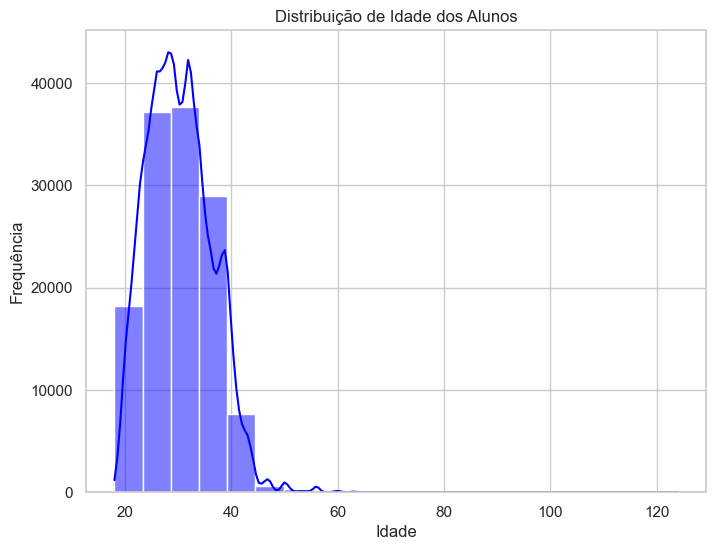

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações de estilo
sns.set(style="whitegrid")

# Histograma da idade
plt.figure(figsize=(8, 6))
sns.histplot(dados_relevantes['IDADE'], bins=20, kde=True, color='blue')
plt.title('Distribuição de Idade dos Alunos')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

### Distribuição de Gênero

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\320462729.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENERO', data=dados_relevantes, palette='Set2')


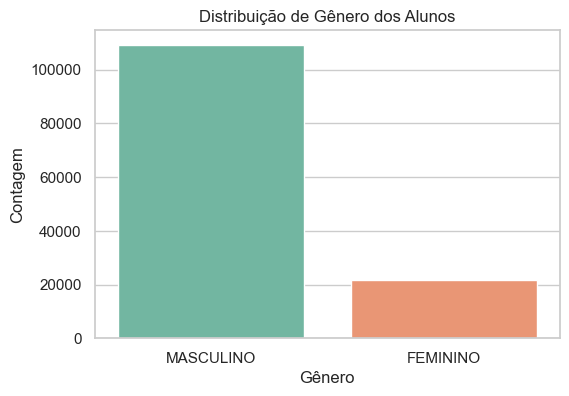

In [39]:
# Contagem de gêneros
plt.figure(figsize=(6, 4))
sns.countplot(x='GENERO', data=dados_relevantes, palette='Set2')
plt.title('Distribuição de Gênero dos Alunos')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.show()

### Distribuição de Política Afirmativa

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\312246021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='POLITICA_AFIRMATIVA', data=dados_relevantes, palette='Set3')


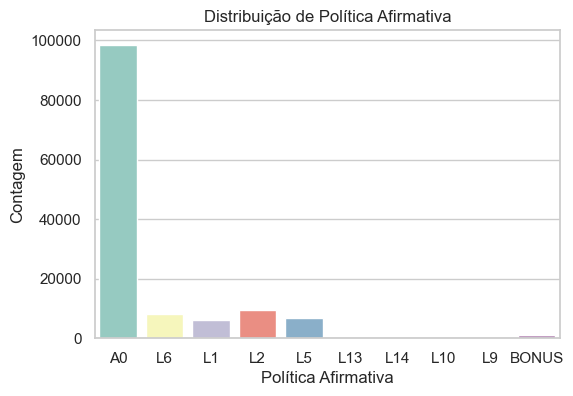

In [40]:
# Contagem de política afirmativa
plt.figure(figsize=(6, 4))
sns.countplot(x='POLITICA_AFIRMATIVA', data=dados_relevantes, palette='Set3')
plt.title('Distribuição de Política Afirmativa')
plt.xlabel('Política Afirmativa')
plt.ylabel('Contagem')
plt.show()

### Distribuição de Tipo de Ensino Médio

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\3324000433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='TIPO_ENSINO_MEDIO', data=dados_relevantes, palette='Set1')


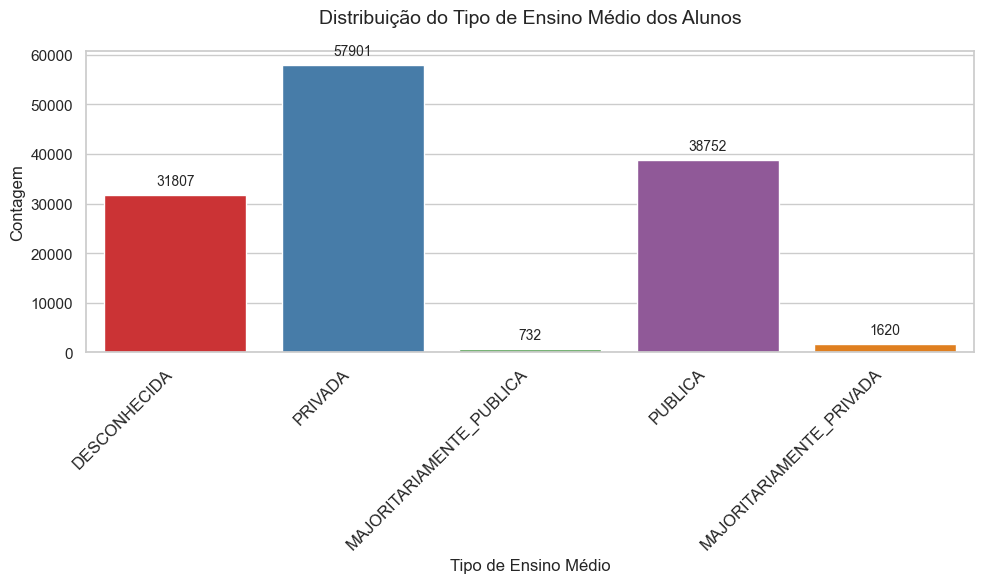

In [41]:
# Contagem de tipo de ensino médio
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='TIPO_ENSINO_MEDIO', data=dados_relevantes, palette='Set1')

# Adicionando contagens em cima das barras
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Valor da contagem
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição do texto
        ha='center',  # Alinhamento horizontal
        va='center',  # Alinhamento vertical
        xytext=(0, 10),  # Deslocamento do texto
        textcoords='offset points',  # Tipo de coordenadas
        fontsize=10  # Tamanho da fonte
    )

# Melhorando os rótulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)  # Inclina os rótulos e ajusta o alinhamento

# Melhorando o título e os rótulos dos eixos
plt.title('Distribuição do Tipo de Ensino Médio dos Alunos', fontsize=14, pad=20)
plt.xlabel('Tipo de Ensino Médio', fontsize=12)
plt.ylabel('Contagem', fontsize=12)

# Ajustando o layout para evitar cortes
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Ano de Formatura no Ensino Médio e Nota 

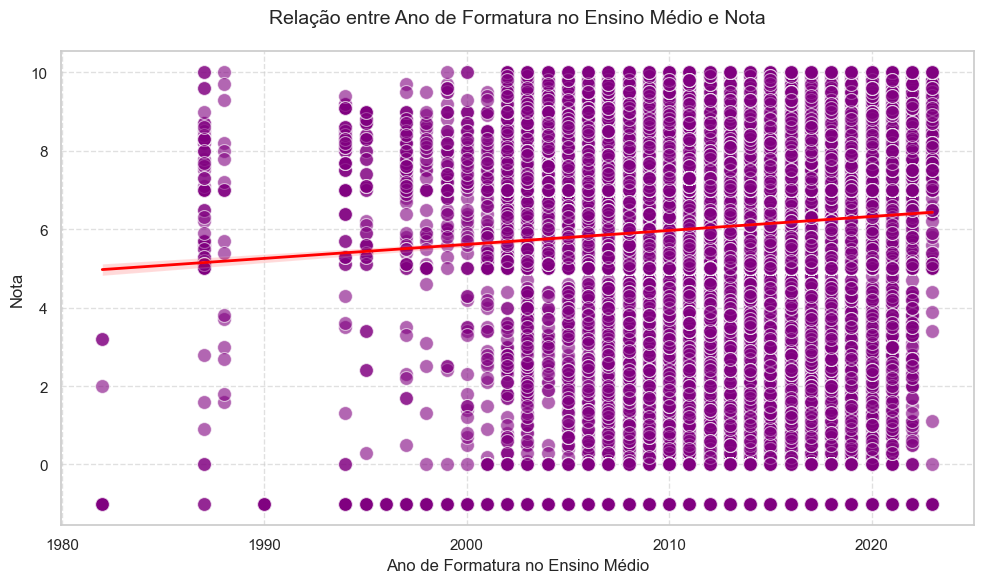

In [42]:
# Gráfico de dispersão: Ano de Formatura vs Nota
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='ANO_FORMATURA_ENSINO_MEDIO', 
    y='NOTA', 
    data=dados_relevantes, 
    alpha=0.6, 
    color='purple', 
    s=100  # Ajusta o tamanho dos pontos
)

# Adicionando uma linha de tendência
sns.regplot(
    x='ANO_FORMATURA_ENSINO_MEDIO', 
    y='NOTA', 
    data=dados_relevantes, 
    scatter=False, 
    color='red', 
    line_kws={'linewidth': 2}
)

# Melhorando o título e os rótulos dos eixos
plt.title('Relação entre Ano de Formatura no Ensino Médio e Nota', fontsize=14, pad=20)
plt.xlabel('Ano de Formatura no Ensino Médio', fontsize=12)
plt.ylabel('Nota', fontsize=12)

# Adicionando uma grade
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18632\3011583016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESTATUS', y='NOTA', data=dados_relevantes, palette='Set2')


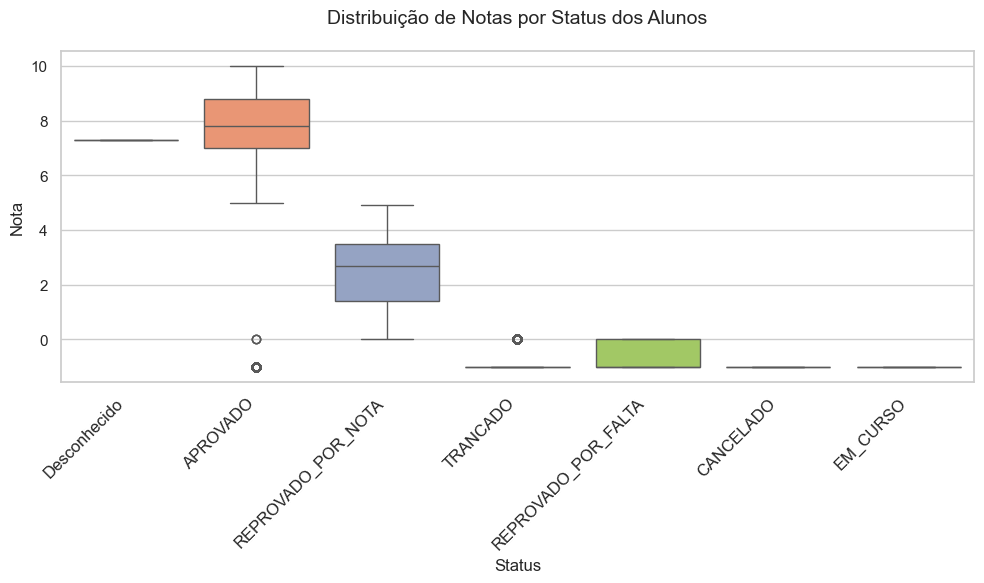

In [43]:
# Boxplot: Nota vs Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='ESTATUS', y='NOTA', data=dados_relevantes, palette='Set2')

# Melhorando os rótulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)  # Inclina os rótulos e ajusta o alinhamento

# Melhorando o título e os rótulos dos eixos
plt.title('Distribuição de Notas por Status dos Alunos', fontsize=14, pad=20)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Nota', fontsize=12)

# Ajustando o layout para evitar cortes
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Gráfico de Barras Agrupadas: Status vs Ano de Formatura

<Figure size 1400x800 with 0 Axes>

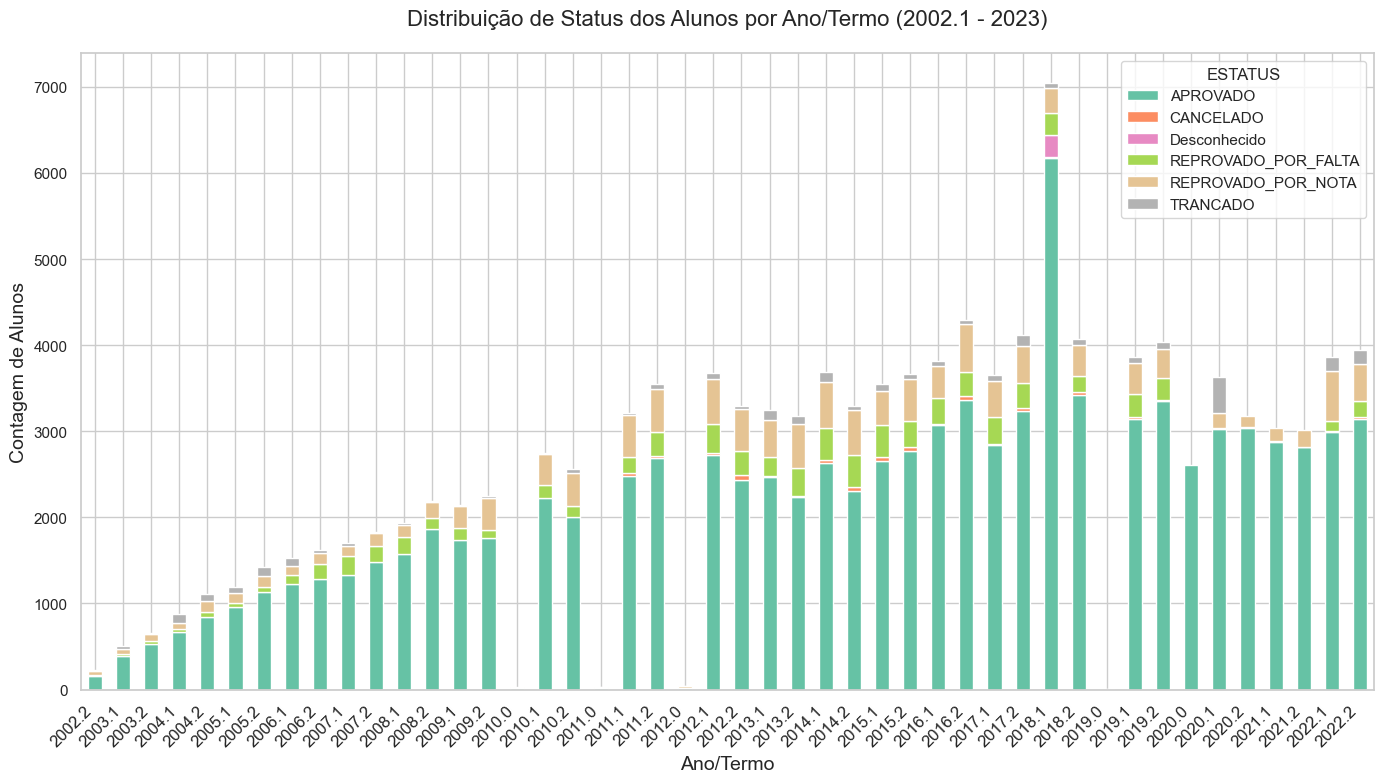

In [44]:
# Criando uma coluna combinando ANO e TERMO (se necessário)
dados_relevantes['ANO_TERMO'] = dados_relevantes['TERMO'].astype(str)

# Filtrando os dados para o período desejado (2002.1 a 2023)
dados_filtrados = dados_relevantes[
    (dados_relevantes['TERMO'] >= 2002.1) & (dados_relevantes['TERMO'] <= 2023)
]

# Agrupando os dados por ANO_TERMO e STATUS
dados_agrupados = dados_filtrados.groupby(['ANO_TERMO', 'ESTATUS']).size().unstack()

# Plotando o gráfico de barras agrupadas
plt.figure(figsize=(14, 8))
dados_agrupados.plot(kind='bar', stacked=True, colormap='Set2', figsize=(14, 8))

# Melhorando o título e os rótulos dos eixos
plt.title('Distribuição de Status dos Alunos por Ano/Termo (2002.1 - 2023)', fontsize=16, pad=20)
plt.xlabel('Ano/Termo', fontsize=14)
plt.ylabel('Contagem de Alunos', fontsize=14)

# Ajustando os rótulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Gráfico de Linhas

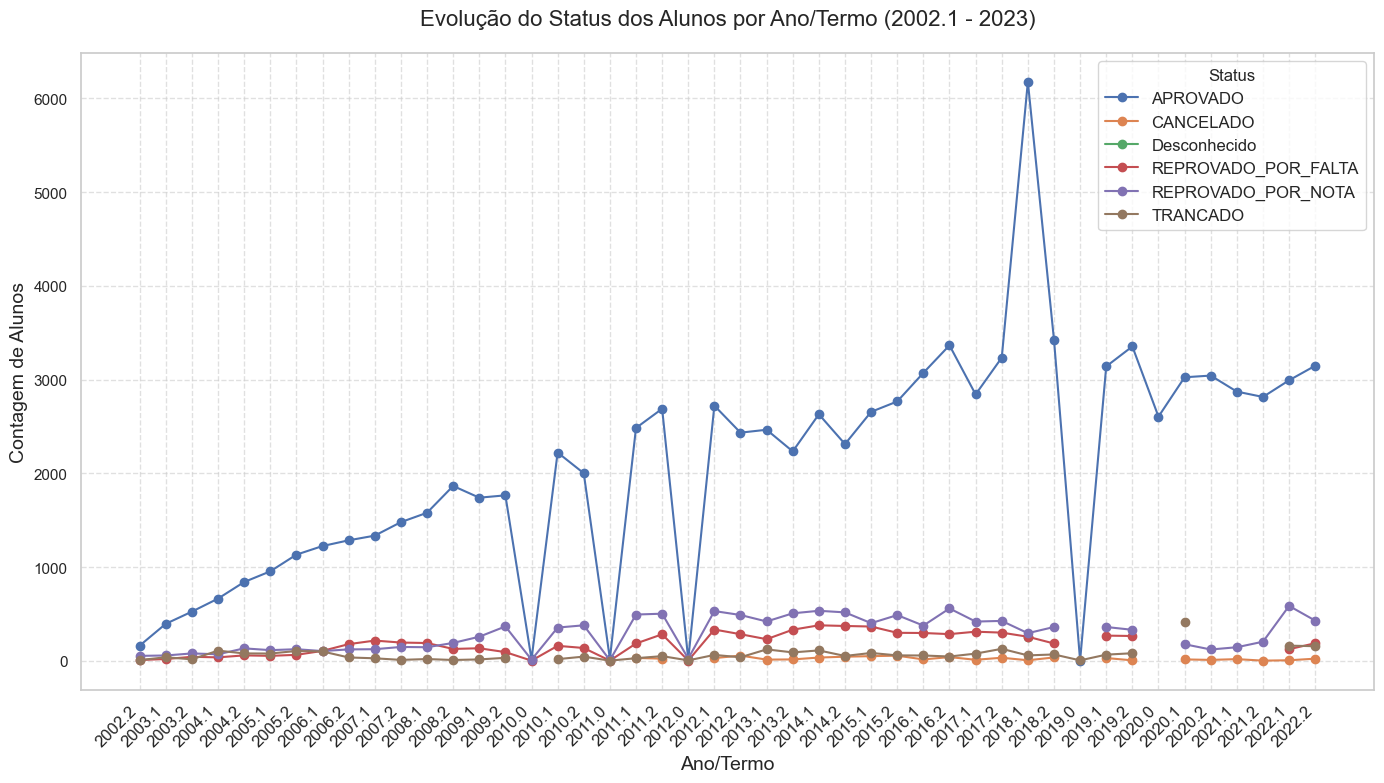

In [45]:
# Plotando o gráfico de linhas
plt.figure(figsize=(14, 8))
for status in dados_agrupados.columns:
    plt.plot(dados_agrupados.index, dados_agrupados[status], marker='o', label=status)

# Melhorando o título e os rótulos dos eixos
plt.title('Evolução do Status dos Alunos por Ano/Termo (2002.1 - 2023)', fontsize=16, pad=20)
plt.xlabel('Ano/Termo', fontsize=14)
plt.ylabel('Contagem de Alunos', fontsize=14)

# Ajustando os rótulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adicionando uma legenda
plt.legend(title='Status', fontsize=12)

# Adicionando uma grade
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Verificar o Número de Linhas

In [46]:
# Verificando o número de linhas e colunas
num_linhas, num_colunas = dados_relevantes.shape
print(f"A base de dados tem {num_linhas} linhas e {num_colunas} colunas.")

A base de dados tem 130812 linhas e 15 colunas.


### Números de alunos

In [47]:
num_alunos = dados_relevantes.shape[0]
print(f"Número total de alunos: {num_alunos}")


Número total de alunos: 130812


In [48]:
num_alunos_unicos = dados_relevantes['MATRICULA'].nunique()
print(f"Número de alunos únicos: {num_alunos_unicos}")


Número de alunos únicos: 3761


### Mostrar Valores Únicos das Variáveis Categóricas

In [49]:
# Listando as colunas categóricas
colunas_categoricas = dados_relevantes.select_dtypes(include=['object']).columns

# Exibindo os valores únicos de cada variável categórica
for coluna in colunas_categoricas:
    valores_unicos = dados_relevantes[coluna].unique()
    print(f"Valores únicos da coluna '{coluna}':")
    print(valores_unicos)
    print("-" * 50)

Valores únicos da coluna 'GENERO':
['MASCULINO' 'FEMININO']
--------------------------------------------------
Valores únicos da coluna 'ESTADO_CIVIL_ALUNOS':
['SOLTEIRO' 'CASADO' 'DESCONHECIDO' 'DIVORCIADO' 'VIUVO']
--------------------------------------------------
Valores únicos da coluna 'NACIONALIDADE':
['BRASILEIRA' 'ESTRANGEIRA' 'BRASILEIRA_POR_NATURALIZACAO']
--------------------------------------------------
Valores únicos da coluna 'ESTADO':
['INATIVO' 'GRADUADO' 'ATIVO']
--------------------------------------------------
Valores únicos da coluna 'RAZAO_INATIVIDADE':
['CANCELAMENTO' 'DESCONHECIDO' 'REINGRESSO' 'ABANDONO' 'EXPULSAO'
 'TRANSFERENCIA' 'OUTROS' 'CONCLUIU_MAS_NAO_COLOU_GRAU' 'DESISTENCIA']
--------------------------------------------------
Valores únicos da coluna 'TIPO_ADMISSAO':
['VESTIBULAR' 'TRANSFERENCIA' 'DECISAO_JUDICIAL_ADM' 'REOPCAO'
 'REINGRESSO' 'CONVENIO' 'SISU' 'GRADUADO']
--------------------------------------------------
Valores únicos da coluna 'PO

Para criar a variável EVASAO, devemos considerar apenas os alunos que evadiram (ou seja, estão INATIVO ou CANCELADO) e os que não evadiram (estão ATIVO). Os alunos que já se formaram (GRADUADO) devem ser desconsiderados da análise, pois eles concluíram o curso com sucesso e não se encaixam na definição de evasão.

Filtrar os dados:
Remover as linhas onde o ESTADO é GRADUADO, pois esses alunos não são relevantes para a análise de evasão.
Criar a variável EVASAO:
Atribuir 1 para alunos que evadiram (INATIVO ou CANCELADO).
Atribuir 0 para alunos que não evadiram (ATIVO).

### Criar a Variável EVASAO

In [50]:
# Filtrando os dados: removendo alunos GRADUADOS
dados_filtrados = dados_relevantes[dados_relevantes['ESTADO'] != 'GRADUADO']

# Criando a variável EVASAO
dados_filtrados['EVASAO'] = dados_filtrados['ESTADO'].apply(
    lambda x: 1 if x in ['INATIVO', 'CANCELADO'] else 0
)

# Verificando a distribuição da variável EVASAO
print("Distribuição da variável EVASAO:")
print(dados_filtrados['EVASAO'].value_counts())

# Exibindo as primeiras linhas do DataFrame filtrado
print("\nPrimeiras linhas do DataFrame filtrado:")
print(dados_filtrados.head())

Distribuição da variável EVASAO:
EVASAO
1    41348
0    23633
Name: count, dtype: int64

Primeiras linhas do DataFrame filtrado:
    MATRICULA  IDADE     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE   ESTADO  \
0   102210001     42  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
91  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
92  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
93  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
94  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   

   RAZAO_INATIVIDADE TIPO_ADMISSAO POLITICA_AFIRMATIVA TIPO_ENSINO_MEDIO  \
0       CANCELAMENTO    VESTIBULAR                  A0      DESCONHECIDA   
91        REINGRESSO    VESTIBULAR                  A0      DESCONHECIDA   
92        REINGRESSO    VESTIBULAR                  A0      DESCONHECIDA   
93        REINGRESSO    VESTIBULAR                  A0      DESCONHECIDA   
94        REINGRESSO  

A distribuição da variável EVASAO mostra que há 41.348 alunos que evadiram (valor 1) e 23.633 alunos que não evadiram (valor 0). Isso indica que, na base de dados atual, há uma proporção maior de evasão em relação aos alunos que permanecem ativos. Essa informação é crucial para a análise, pois já nos dá uma ideia do cenário de evasão no curso.

No entanto, é importante destacar que ainda não aplicamos nenhum modelo de Machine Learning. Neste momento, apenas criamos a variável EVASAO com base na coluna ESTADO, onde:

1 representa alunos que evadiram (estão INATIVO ou CANCELADO).
0 representa alunos que não evadiram (estão ATIVO).

Os alunos GRADUADOS foram desconsiderados da análise, pois eles concluíram o curso com sucesso e não se enquadram na definição de evasão.


###  Gráfico de Pizza

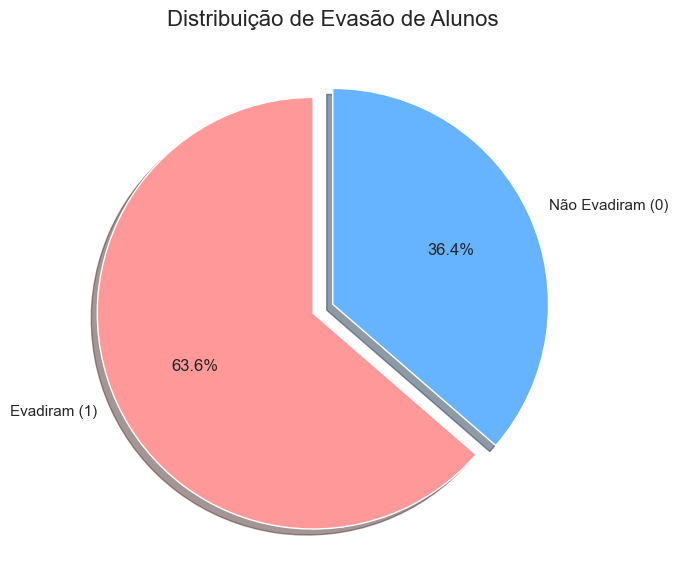

In [51]:
import matplotlib.pyplot as plt

# Contagem de valores da variável EVASAO
contagem_evasao = dados_filtrados['EVASAO'].value_counts()

# Rótulos para o gráfico
labels = ['Evadiram (1)', 'Não Evadiram (0)']

# Valores para o gráfico
sizes = contagem_evasao.values

# Cores para cada fatia
colors = ['#ff9999', '#66b3ff']

# Explodir a fatia "Evadiram" para destacá-la
explode = (0.1, 0)

# Criando o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)

# Adicionando título
plt.title('Distribuição de Evasão de Alunos', fontsize=16)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

A distribuição da variável EVASAO mostra que há 41.348 alunos que evadiram (valor 1) e 23.633 alunos que não evadiram (valor 0). Isso indica que, na base de dados atual, 63,6% dos alunos evadiram, enquanto 36,4% permaneceram ativos. Essa proporção revela um cenário significativo de evasão no curso, destacando a importância de entender os fatores que contribuem para esse fenômeno.

É importante ressaltar que, antes de criar a variável EVASAO, os alunos GRADUADOS foram removidos da análise, pois eles concluíram o curso com sucesso e, portanto, não se enquadram na definição de evasão. A variável EVASAO foi construída com base na coluna ESTADO, onde:

1 representa alunos que evadiram (estão INATIVO ou CANCELADO).

0 representa alunos que não evadiram (estão ATIVO).

Essa etapa é preliminar e ainda não aplicamos nenhum modelo de Machine Learning. O objetivo, por enquanto, foi preparar os dados e criar a variável alvo (EVASAO) para futuras análises e modelagem. A próxima etapa envolverá o balanceamento dos dados, a codificação das variáveis categóricas e a aplicação de algoritmos de classificação para prever a evasão.

### Verificar o Intervalo de Anos

In [52]:
# Extraindo o ano da coluna ANO_TERMO
dados_relevantes['ANO'] = dados_relevantes['ANO_TERMO'].apply(lambda x: int(str(x).split('.')[0]))

# Verificando o ano mínimo e máximo
ano_inicio = dados_relevantes['ANO'].min()
ano_fim = dados_relevantes['ANO'].max()

print(f"O intervalo de anos na base é de {ano_inicio} a {ano_fim}.")

O intervalo de anos na base é de 2002 a 2024.


### Codificar Variáveis Categóricas

Agora que já criamos a variável EVASAO, o próximo passo é codificar as variáveis categóricas para preparar os dados para modelos de Machine Learning. Vamos usar duas técnicas principais:

One-Hot Encoding: Para variáveis categóricas nominais (ex: GÊNERO, NACIONALIDADE).
Label Encoding: Para variáveis categóricas ordinais (ex: ESTADO_CIVIL_ALUNOS, TIPO_ENSINO_MEDIO).

In [53]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 1. One-Hot Encoding para variáveis nominais
colunas_one_hot = ['GENERO', 'NACIONALIDADE', 'TIPO_ADMISSAO', 'POLITICA_AFIRMATIVA']
dados_codificados = pd.get_dummies(dados_filtrados, columns=colunas_one_hot, drop_first=True)

# 2. Label Encoding para variáveis ordinais
colunas_label_encode = ['ESTADO_CIVIL_ALUNOS', 'TIPO_ENSINO_MEDIO', 'RAZAO_INATIVIDADE', 'ESTATUS']
label_encoder = LabelEncoder()
for coluna in colunas_label_encode:
    dados_codificados[coluna] = label_encoder.fit_transform(dados_filtrados[coluna])

# 3. Exibindo as primeiras linhas do DataFrame codificado
print("Primeiras linhas do DataFrame codificado:")
print(dados_codificados.head())

# 4. Verificando as colunas após a codificação
print("\nColunas após a codificação:")
print(dados_codificados.columns)

Primeiras linhas do DataFrame codificado:
    MATRICULA  IDADE  ESTADO_CIVIL_ALUNOS   ESTADO  RAZAO_INATIVIDADE  \
0   102210001     42                    3  INATIVO                  1   
91  102210003     40                    3  INATIVO                  7   
92  102210003     40                    3  INATIVO                  7   
93  102210003     40                    3  INATIVO                  7   
94  102210003     40                    3  INATIVO                  7   

    TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  NOTA  ESTATUS   TERMO  ...  \
0                   0                      2011.0   7.3        2  2018.1  ...   
91                  0                      2011.0  -1.0        6  2002.2  ...   
92                  0                      2011.0   2.0        5  2002.2  ...   
93                  0                      2011.0  -1.0        6  2002.2  ...   
94                  0                      2011.0   7.4        0  2002.2  ...   

   TIPO_ADMISSAO_VESTIBULAR  POL

As variáveis categóricas foram transformadas em formatos numéricos, permitindo que algoritmos de Machine Learning processem os dados.
O uso de One-Hot Encoding para variáveis nominais evitou a criação de hierarquias artificiais.
O uso de Label Encoding para variáveis ordinais preservou a ordem natural das categorias.
A coluna EVASAO (nossa variável alvo) permaneceu intacta, pronta para ser usada no treinamento do modelo.

### Balanceamento de Dados:

 Balanceamento de Dados. A variável EVASAO está desbalanceada, com 63,6% dos alunos evadidos e 36,4% não evadidos. Para garantir que o modelo de Machine Learning não seja tendencioso em favor da classe majoritária (evadidos), precisamos balancear os dados. Vamos usar a técnica de undersampling, que reduz o número de amostras da classe majoritária para igualar à classe minoritária.

O balanceamento é aplicado ao conjunto completo de dados, incluindo todas as variáveis independentes (features) e a variável alvo (EVASAO).
O objetivo é garantir que a proporção entre as classes da variável alvo (EVASAO) seja equilibrada.
Após o balanceamento, todas as variáveis independentes e a variável alvo são mantidas no DataFrame balanceado.

In [54]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 1. Balanceamento dos dados
classe_maioritaria = dados_codificados[dados_codificados['EVASAO'] == 1]
classe_minoritaria = dados_codificados[dados_codificados['EVASAO'] == 0]

classe_maioritaria_undersampled = resample(
    classe_maioritaria,
    replace=False,
    n_samples=len(classe_minoritaria),
    random_state=42
)

dados_balanceados = pd.concat([classe_maioritaria_undersampled, classe_minoritaria])

###  Divisão dos Dados em Treino e Teste

In [55]:
# 2. Divisão dos dados em treino e teste
X = dados_balanceados.drop(columns=['EVASAO'])  # Todas as colunas, exceto EVASAO
y = dados_balanceados['EVASAO']  # Apenas a coluna EVASAO

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Verificando os tamanhos

In [56]:
# Verificando os tamanhos
print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 37812 amostras
Tamanho do conjunto de teste: 9454 amostras


Essa divisão garante que:
80% dos dados serão usados para treinar o modelo.
20% dos dados serão usados para avaliar o modelo em dados não vistos durante o treinamento.

### Treinamento dos Modelos
Vamos treinar três modelos:

Regressão Logística: Um modelo simples e interpretável.
Random Forest: Um modelo baseado em árvores de decisão, robusto e com boa performance.
XGBoost: Um modelo avançado baseado em boosting, conhecido por sua alta precisão.

### Instalação das Bibliotecas Necessárias

In [57]:
pip install scikit-learn xgboost mlflow joblib


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
# Verificando colunas categóricas não codificadas
colunas_nao_numericas = dados_balanceados.select_dtypes(include=['object']).columns
print("Colunas categóricas não codificadas:")
print(colunas_nao_numericas)

Colunas categóricas não codificadas:
Index(['ESTADO', 'ANO_TERMO'], dtype='object')


In [59]:
# Removendo a coluna ESTADO
dados_codificados = dados_balanceados.drop(columns=['ESTADO'])

In [60]:
# Tratar ANO_TERMO
# Extraindo o ano e o semestre da coluna ANO_TERMO
dados_codificados['ANO'] = dados_codificados['ANO_TERMO'].apply(lambda x: int(str(x).split('.')[0]))
dados_codificados['SEMESTRE'] = dados_codificados['ANO_TERMO'].apply(lambda x: int(str(x).split('.')[1]))

# Removendo a coluna ANO_TERMO original
dados_codificados = dados_codificados.drop(columns=['ANO_TERMO'])

In [61]:
# Verificando as primeiras linhas do DataFrame após o tratamento
print("Primeiras linhas do DataFrame após o tratamento de ANO_TERMO:")
print(dados_codificados[['ANO', 'SEMESTRE']].head())

Primeiras linhas do DataFrame após o tratamento de ANO_TERMO:
        ANO  SEMESTRE
97726  2023         1
71901  2020         1
67908  2016         1
34141  2012         2
40463  2011         2


In [62]:
# Verificando as colunas do DataFrame
print("Colunas disponíveis no DataFrame:")
print(dados_codificados.columns)

Colunas disponíveis no DataFrame:
Index(['MATRICULA', 'IDADE', 'ESTADO_CIVIL_ALUNOS', 'RAZAO_INATIVIDADE',
       'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS',
       'TERMO', 'EVASAO', 'GENERO_MASCULINO',
       'NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO',
       'NACIONALIDADE_ESTRANGEIRA', 'TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM',
       'TIPO_ADMISSAO_GRADUADO', 'TIPO_ADMISSAO_REOPCAO', 'TIPO_ADMISSAO_SISU',
       'TIPO_ADMISSAO_TRANSFERENCIA', 'TIPO_ADMISSAO_VESTIBULAR',
       'POLITICA_AFIRMATIVA_BONUS', 'POLITICA_AFIRMATIVA_L1',
       'POLITICA_AFIRMATIVA_L10', 'POLITICA_AFIRMATIVA_L13',
       'POLITICA_AFIRMATIVA_L14', 'POLITICA_AFIRMATIVA_L2',
       'POLITICA_AFIRMATIVA_L5', 'POLITICA_AFIRMATIVA_L6',
       'POLITICA_AFIRMATIVA_L9', 'ANO', 'SEMESTRE'],
      dtype='object')


In [63]:
# Verificando os tipos de dados das colunas
print("Tipos de dados das colunas:")
print(dados_codificados.dtypes)

Tipos de dados das colunas:
MATRICULA                                       int64
IDADE                                           int64
ESTADO_CIVIL_ALUNOS                             int64
RAZAO_INATIVIDADE                               int64
TIPO_ENSINO_MEDIO                               int64
ANO_FORMATURA_ENSINO_MEDIO                    float64
NOTA                                          float64
ESTATUS                                         int64
TERMO                                         float64
EVASAO                                          int64
GENERO_MASCULINO                                 bool
NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO       bool
NACIONALIDADE_ESTRANGEIRA                        bool
TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM               bool
TIPO_ADMISSAO_GRADUADO                           bool
TIPO_ADMISSAO_REOPCAO                            bool
TIPO_ADMISSAO_SISU                               bool
TIPO_ADMISSAO_TRANSFERENCIA                      bool


### Corrigir os Tipos de Dados
Convertendo Colunas Booleanas para Inteiras

In [64]:
# Convertendo colunas booleanas para inteiras
colunas_bool = dados_codificados.select_dtypes(include=['bool']).columns
dados_codificados[colunas_bool] = dados_codificados[colunas_bool].astype(int)

# Verificando os tipos de dados após a conversão
print("\nTipos de dados após conversão de booleanos para inteiros:")
print(dados_codificados.dtypes)


Tipos de dados após conversão de booleanos para inteiros:
MATRICULA                                       int64
IDADE                                           int64
ESTADO_CIVIL_ALUNOS                             int64
RAZAO_INATIVIDADE                               int64
TIPO_ENSINO_MEDIO                               int64
ANO_FORMATURA_ENSINO_MEDIO                    float64
NOTA                                          float64
ESTATUS                                         int64
TERMO                                         float64
EVASAO                                          int64
GENERO_MASCULINO                                int64
NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO      int64
NACIONALIDADE_ESTRANGEIRA                       int64
TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM              int64
TIPO_ADMISSAO_GRADUADO                          int64
TIPO_ADMISSAO_REOPCAO                           int64
TIPO_ADMISSAO_SISU                              int64
TIPO_ADMISSAO_TRANSFERE

Verificando Colunas Categóricas Restantes

In [65]:
# Verificando colunas categóricas não codificadas
colunas_nao_numericas = dados_codificados.select_dtypes(include=['object']).columns
print("\nColunas categóricas não codificadas:")
print(colunas_nao_numericas)


Colunas categóricas não codificadas:
Index([], dtype='object')


In [66]:
# Visualizando as primeiras linhas do DataFrame
print(dados_codificados.head())

# Verificando as colunas disponíveis
print(dados_codificados.columns)

# Verificando algumas estatísticas descritivas
print(dados_codificados.describe())

# Verificando a distribuição da variável alvo 'EVASAO'
print(dados_codificados['EVASAO'].value_counts())

       MATRICULA  IDADE  ESTADO_CIVIL_ALUNOS  RAZAO_INATIVIDADE  \
97726  118110711     24                    3                  5   
71901  115210432     29                    3                  2   
67908  115110811     28                    3                  5   
34141  110210386     33                    3                  7   
40463  111210434     31                    0                  0   

       TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  NOTA  ESTATUS   TERMO  \
97726                  4                      2017.0   0.0        5  2023.1   
71901                  4                      2014.0   7.8        0  2020.1   
67908                  4                      2014.0   7.2        0  2016.1   
34141                  3                      2009.0   1.7        5  2012.2   
40463                  2                      2010.0   6.5        0  2011.2   

       EVASAO  ...  POLITICA_AFIRMATIVA_L1  POLITICA_AFIRMATIVA_L10  \
97726       1  ...                       1         

### Divisão dos Dados

In [67]:
from sklearn.model_selection import train_test_split

# Definindo as variáveis independentes (X) e a variável dependente (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Todas as colunas, exceto a variável alvo
y = dados_codificados['EVASAO']  # Apenas a coluna EVASAO

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42  # Semente para reprodutibilidade
)

# Verificando o tamanho dos conjuntos
print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 37812 amostras
Tamanho do conjunto de teste: 9454 amostras


### Regressão Logística

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Criando e treinando o modelo de Regressão Logística
modelo_rl = LogisticRegression(max_iter=1000)
modelo_rl.fit(X_train, y_train)

# Fazendo previsões
y_pred_rl = modelo_rl.predict(X_test)

# Avaliação do modelo
acuracia_rl = accuracy_score(y_test, y_pred_rl)
precisao_rl = precision_score(y_test, y_pred_rl, average='weighted')
recall_rl = recall_score(y_test, y_pred_rl, average='weighted')
f1_rl = f1_score(y_test, y_pred_rl, average='weighted')

print("\n🔹 Regressão Logística:")
print(f"Acurácia: {acuracia_rl:.4f}")
print(f"Precisão: {precisao_rl:.4f}")
print(f"Recall: {recall_rl:.4f}")
print(f"F1-Score: {f1_rl:.4f}")



🔹 Regressão Logística:
Acurácia: 0.8702
Precisão: 0.8760
Recall: 0.8702
F1-Score: 0.8696


### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Criando e treinando o modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Fazendo previsões
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação do modelo
acuracia_rf = accuracy_score(y_test, y_pred_rf)
precisao_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\n🔹 Random Forest:")
print(f"Acurácia: {acuracia_rf:.4f}")
print(f"Precisão: {precisao_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")



🔹 Random Forest:
Acurácia: 0.9999
Precisão: 0.9999
Recall: 0.9999
F1-Score: 0.9999


###  XGBoost

In [70]:
from xgboost import XGBClassifier

# Criando e treinando o modelo XGBoost
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modelo_xgb.fit(X_train, y_train)

# Fazendo previsões
y_pred_xgb = modelo_xgb.predict(X_test)

# Avaliação do modelo
acuracia_xgb = accuracy_score(y_test, y_pred_xgb)
precisao_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("\n🔹 XGBoost:")
print(f"Acurácia: {acuracia_xgb:.4f}")
print(f"Precisão: {precisao_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")



🔹 XGBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
from sklearn.neighbors import KNeighborsClassifier

# Criando e treinando o modelo KNN
modelo_knn = KNeighborsClassifier(n_neighbors=5)  # Número de vizinhos = 5 (pode ajustar conforme necessário)
modelo_knn.fit(X_train, y_train)

# Fazendo previsões
y_pred_knn = modelo_knn.predict(X_test)

# Avaliação do modelo
acuracia_knn = accuracy_score(y_test, y_pred_knn)
precisao_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("\n🔹 KNN:")
print(f"Acurácia: {acuracia_knn:.4f}")
print(f"Precisão: {precisao_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-Score: {f1_knn:.4f}")



🔹 KNN:
Acurácia: 0.9801
Precisão: 0.9802
Recall: 0.9801
F1-Score: 0.9801


In [72]:
from sklearn.ensemble import AdaBoostClassifier

# Criando e treinando o modelo AdaBoost
modelo_ada = AdaBoostClassifier(n_estimators=50, random_state=42)  # 50 estimadores (pode ajustar)
modelo_ada.fit(X_train, y_train)

# Fazendo previsões
y_pred_ada = modelo_ada.predict(X_test)

# Avaliação do modelo
acuracia_ada = accuracy_score(y_test, y_pred_ada)
precisao_ada = precision_score(y_test, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test, y_pred_ada, average='weighted')

print("\n🔹 AdaBoost:")
print(f"Acurácia: {acuracia_ada:.4f}")
print(f"Precisão: {precisao_ada:.4f}")
print(f"Recall: {recall_ada:.4f}")
print(f"F1-Score: {f1_ada:.4f}")



🔹 AdaBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [73]:
from sklearn.svm import SVC

# Criando e treinando o modelo SVC
modelo_svc = SVC(kernel='rbf', probability=True, random_state=42)  # Kernel RBF (padrão)
modelo_svc.fit(X_train, y_train)

# Fazendo previsões
y_pred_svc = modelo_svc.predict(X_test)

# Avaliação do modelo
acuracia_svc = accuracy_score(y_test, y_pred_svc)
precisao_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

print("\n🔹 SVC (Support Vector Classifier):")
print(f"Acurácia: {acuracia_svc:.4f}")
print(f"Precisão: {precisao_svc:.4f}")
print(f"Recall: {recall_svc:.4f}")
print(f"F1-Score: {f1_svc:.4f}")



🔹 SVC (Support Vector Classifier):
Acurácia: 0.8737
Precisão: 0.8808
Recall: 0.8737
F1-Score: 0.8730


1. Overfitting (Superajuste)
O modelo pode ter memorizado os dados de treino em vez de aprender padrões reais. Isso é comum em modelos como Random Forest, XGBoost e AdaBoost, que são muito expressivos e podem se ajustar perfeitamente ao conjunto de treino.
Se o conjunto de teste for pequeno ou muito semelhante ao de treino, o modelo pode simplesmente memorizar as respostas corretas.


### Trabalho relacionado Allan

### Modelo Global vs Modelo Específico

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Definindo as variáveis independentes (X) e a variável dependente (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Todas as colunas, exceto a variável alvo
y = dados_codificados['EVASAO']  # Apenas a coluna EVASAO

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Criando Modelo Global (todos os dados)
modelo_global = RandomForestClassifier(random_state=42)
modelo_global.fit(X_train, y_train)

# Criando Modelo Específico (apenas alunos de escola pública)
X_train_especifico = X_train[X_train['TIPO_ENSINO_MEDIO'] == 1]
y_train_especifico = y_train.loc[X_train_especifico.index]  # Filtrar y correspondente

modelo_especifico = RandomForestClassifier(random_state=42)
modelo_especifico.fit(X_train_especifico, y_train_especifico)

# Avaliação do Modelo Global
y_pred_global = modelo_global.predict(X_test)
print("Resultados do Modelo Global:")
print(classification_report(y_test, y_pred_global))

# Avaliação do Modelo Específico (aplicado apenas no subconjunto do teste)
X_test_especifico = X_test[X_test['TIPO_ENSINO_MEDIO'] == 1]
y_test_especifico = y_test.loc[X_test_especifico.index]
y_pred_especifico = modelo_especifico.predict(X_test_especifico)

print("\nResultados do Modelo Específico:")
print(classification_report(y_test_especifico, y_pred_especifico))


Resultados do Modelo Global:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4772
           1       1.00      1.00      1.00      4682

    accuracy                           1.00      9454
   macro avg       1.00      1.00      1.00      9454
weighted avg       1.00      1.00      1.00      9454


Resultados do Modelo Específico:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        80

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



In [75]:
print("Colunas disponíveis:", dados_codificados.columns)


Colunas disponíveis: Index(['MATRICULA', 'IDADE', 'ESTADO_CIVIL_ALUNOS', 'RAZAO_INATIVIDADE',
       'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS',
       'TERMO', 'EVASAO', 'GENERO_MASCULINO',
       'NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO',
       'NACIONALIDADE_ESTRANGEIRA', 'TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM',
       'TIPO_ADMISSAO_GRADUADO', 'TIPO_ADMISSAO_REOPCAO', 'TIPO_ADMISSAO_SISU',
       'TIPO_ADMISSAO_TRANSFERENCIA', 'TIPO_ADMISSAO_VESTIBULAR',
       'POLITICA_AFIRMATIVA_BONUS', 'POLITICA_AFIRMATIVA_L1',
       'POLITICA_AFIRMATIVA_L10', 'POLITICA_AFIRMATIVA_L13',
       'POLITICA_AFIRMATIVA_L14', 'POLITICA_AFIRMATIVA_L2',
       'POLITICA_AFIRMATIVA_L5', 'POLITICA_AFIRMATIVA_L6',
       'POLITICA_AFIRMATIVA_L9', 'ANO', 'SEMESTRE'],
      dtype='object')


### Inicializar o DVC no Repositório

In [76]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurar o diretório de logs novamente (para garantir)
mlflow.set_tracking_uri(f"file:///{caminho_logs}")

# Definir o nome do experimento
mlflow.set_experiment("Evasao_UFCG")

# Definir as variáveis independentes (X) e a variável alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a variável-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a variável de saída (1 = Evadiu, 0 = Não evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a proporção de evasão se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e avaliar modelos
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar o MLflow para cada modelo
    with mlflow.start_run():
        # Registrar parâmetros do modelo (exemplo: hiperparâmetros)
        mlflow.log_param("modelo", nome)
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)  
        y_pred = modelo.predict(X_test)  # Fazendo previsões

        # Calculando métricas de avaliação
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Armazenando os resultados
        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

        # Registrar métricas no MLflow
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        print(f"{nome} - Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regressão Logística...
Regressão Logística - Acurácia: 0.8736, Precisão: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...
Random Forest - Acurácia: 0.9999, Precisão: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


###  MLflow para Salvar os Experimentes

In [77]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

### Processo de registro no MLflow para monitoramento de métricas e execução.

In [78]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir o URI de rastreamento do MLflow
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow/mlruns")

# Definir o nome do experimento
mlflow.set_experiment("Treinamento_Modelos")

# Definir as variáveis independentes (X) e a variável alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a variável-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a variável de saída (1 = Evadiu, 0 = Não evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a proporção de evasão se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar um experimento no MLflow
    with mlflow.start_run():
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previsões
        
        # Calculando métricas de avaliação
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar métricas no MLflow
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
        else:
            mlflow.sklearn.log_model(modelo, "model")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }
        
        print(f"{nome} - Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")



Treinando Regressão Logística...


2025/05/05 14:50:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressão Logística - Acurácia: 0.8736, Precisão: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...


2025/05/05 14:50:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Acurácia: 0.9999, Precisão: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/05 14:51:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


###  Visualizar no MLflow

In [79]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URL de rastreamento do MLflow (diretório dos experimentos)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")

# Definir o nome do experimento
mlflow.set_experiment("Treinamento_Modelos")

# Definir as variáveis independentes (X) e a variável alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a variável-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a variável de saída (1 = Evadiu, 0 = Não evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a proporção de evasão se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar um experimento no MLflow
    with mlflow.start_run():
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previsões
        
        # Calculando métricas de avaliação
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar métricas no MLflow
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
            print(f"Modelo {nome} salvo no MLflow.")
        else:
            mlflow.sklearn.log_model(modelo, "model")
            print(f"Modelo {nome} salvo no MLflow.")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }
        
        print(f"{nome} - Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regressão Logística...


2025/05/05 14:51:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regressão Logística salvo no MLflow.
Regressão Logística - Acurácia: 0.8736, Precisão: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...


2025/05/05 14:51:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.
Random Forest - Acurácia: 0.9999, Precisão: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/05 14:51:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo XGBoost salvo no MLflow.
XGBoost - Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [80]:
import mlflow

# Listar todos os experimentos
experimentos = mlflow.search_experiments()
for exp in experimentos:
    print(f"ID: {exp.experiment_id}, Nome: {exp.name}")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

ID: 606799937749384898, Nome: Treinamento_Modelos
ID: 280216387810933266, Nome: Carregamento de Dados UFCG
ID: 973689039483717455, Nome: Evasao_UFCG


In [81]:
import mlflow

# Listar execuções do experimento
experimento = mlflow.get_experiment_by_name("Treinamento_Modelos")
if experimento:
    execucoes = mlflow.search_runs(experimento.experiment_id)
    print(execucoes)
else:
    print("Experimento não encontrado.")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

                              run_id       experiment_id    status  \
0   1a64d6123ddb43b5a4da7ae84a86cfa6  606799937749384898  FINISHED   
1   6771f546b5e3427682c511643cc8150e  606799937749384898  FINISHED   
2   310a8ad9c12f41638235f634df9199a2  606799937749384898  FINISHED   
3   b817a1b9df14469a986387a8e0809401  606799937749384898   RUNNING   
4   196008a60f3748dd9f84bf3aedd93be0  606799937749384898  FINISHED   
..                               ...                 ...       ...   
73  5be7786d20d14f31aba608288af65b63  606799937749384898  FINISHED   
74  058e5daf4302411889dade05fcf727b0  606799937749384898  FINISHED   
75  cc97903b3d1a44d3aaaadc582ea2c554  606799937749384898  FINISHED   
76  99b0106fa996454999eb96b4f2031854  606799937749384898  FINISHED   
77  c4e5f23963bf4fa3a97a4fe8cae5fd20  606799937749384898  FINISHED   

                                         artifact_uri  \
0   file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   
1   file:///E:/Mestrado UFCG/Semestre 2024.2/

In [82]:
import mlflow

# Listar todos os experimentos
experimentos = mlflow.search_experiments()
for exp in experimentos:
    print(f"ID: {exp.experiment_id}, Nome: {exp.name}")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

ID: 606799937749384898, Nome: Treinamento_Modelos
ID: 280216387810933266, Nome: Carregamento de Dados UFCG
ID: 973689039483717455, Nome: Evasao_UFCG


In [83]:
import mlflow

# Listar execuções do experimento
experimento = mlflow.get_experiment_by_name("Treinamento_Modelos")
if experimento:
    execucoes = mlflow.search_runs(experimento.experiment_id)
    print(execucoes)
else:
    print("Experimento não encontrado.")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

                              run_id       experiment_id    status  \
0   1a64d6123ddb43b5a4da7ae84a86cfa6  606799937749384898  FINISHED   
1   6771f546b5e3427682c511643cc8150e  606799937749384898  FINISHED   
2   310a8ad9c12f41638235f634df9199a2  606799937749384898  FINISHED   
3   b817a1b9df14469a986387a8e0809401  606799937749384898   RUNNING   
4   196008a60f3748dd9f84bf3aedd93be0  606799937749384898  FINISHED   
..                               ...                 ...       ...   
73  5be7786d20d14f31aba608288af65b63  606799937749384898  FINISHED   
74  058e5daf4302411889dade05fcf727b0  606799937749384898  FINISHED   
75  cc97903b3d1a44d3aaaadc582ea2c554  606799937749384898  FINISHED   
76  99b0106fa996454999eb96b4f2031854  606799937749384898  FINISHED   
77  c4e5f23963bf4fa3a97a4fe8cae5fd20  606799937749384898  FINISHED   

                                         artifact_uri  \
0   file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   
1   file:///E:/Mestrado UFCG/Semestre 2024.2/

In [84]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experimentos = client.search_experiments()  # Lista todos os experimentos
for exp in experimentos:
    print(f"ID: {exp.experiment_id}, Nome: {exp.name}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

ID: 606799937749384898, Nome: Treinamento_Modelos
ID: 280216387810933266, Nome: Carregamento de Dados UFCG
ID: 973689039483717455, Nome: Evasao_UFCG


In [85]:
import mlflow
print(mlflow.get_tracking_uri())


file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow


In [87]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuração do MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Defina o tracking server
mlflow.set_experiment("Predição de Evasão - UFCG")  # Nome do experimento

# Definir as variáveis independentes (X) e a variável alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a variável-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a variável de saída (1 = Evadiu, 0 = Não evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a proporção de evasão se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome):  # Criar um "run" no MLflow
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo

        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previsões
        
        # Calculando métricas de avaliação
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar métricas no MLflow
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo treinado no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, f"modelos/{nome}")
        else:
            mlflow.sklearn.log_model(modelo, f"modelos/{nome}")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

        print(f"{nome} - Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


2025/05/05 15:09:31 INFO mlflow.tracking.fluent: Experiment with name 'Predição de Evasão - UFCG' does not exist. Creating a new experiment.



Treinando Regressão Logística...


2025/05/05 15:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressão Logística - Acurácia: 0.8736, Precisão: 0.9274, Recall: 0.8107, F1-Score: 0.8651
🏃 View run Regressão Logística at: http://localhost:5000/#/experiments/1/runs/93ead250841f49c9be3703c2324a692a
🧪 View experiment at: http://localhost:5000/#/experiments/1

Treinando Random Forest...


2025/05/05 15:09:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Acurácia: 0.9999, Precisão: 1.0000, Recall: 0.9998, F1-Score: 0.9999
🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/01d38891e2d5417dba237f0bc4be7047
🧪 View experiment at: http://localhost:5000/#/experiments/1

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/05 15:09:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000
🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/b0f69d05584048afb0f736b8b6787608
🧪 View experiment at: http://localhost:5000/#/experiments/1

Resultados dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [88]:
import matplotlib.pyplot as plt
import numpy as np
import mlflow

# Criar gráficos para cada modelo
for nome, modelo in modelos.items():
    # Fazer previsões no conjunto de teste
    y_pred = modelo.predict(X_test)
    
    # Contar quantos alunos foram realmente previstos como evadidos e não evadidos
    evadidos = sum(y_pred == 1)
    nao_evadidos = sum(y_pred == 0)

    plt.figure(figsize=(6, 4))
    plt.bar(["Não Evadiram", "Evadiram"], [nao_evadidos, evadidos], color=['blue', 'red'])

    # Adicionar rótulos numéricos dentro das barras
    plt.text(0, nao_evadidos + 1, str(nao_evadidos), ha='center', fontsize=12, fontweight='bold')
    plt.text(1, evadidos + 1, str(evadidos), ha='center', fontsize=12, fontweight='bold')

    plt.xlabel("Situação do Aluno")
    plt.ylabel("Número de Alunos")
    plt.title(f"Previsão de Evasão - {nome}")
    plt.ylim(0, max(nao_evadidos, evadidos) + 5)  # Ajusta a escala do gráfico

    # Salvar gráfico no MLflow
    grafico_path = f"grafico_{nome.replace(' ', '_')}.png"
    plt.savefig(grafico_path)
    plt.close()

    # Registrar o gráfico no MLflow
    with mlflow.start_run():
        mlflow.log_artifact(grafico_path)


🏃 View run funny-gull-139 at: http://localhost:5000/#/experiments/1/runs/ec86b47d6d3b4d8f96749f1e52722468
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run entertaining-koi-901 at: http://localhost:5000/#/experiments/1/runs/99a0b4909322457b8fa3494f04699ff7
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run peaceful-bat-469 at: http://localhost:5000/#/experiments/1/runs/265b16e728234c5db9afec927d80cda9
🧪 View experiment at: http://localhost:5000/#/experiments/1


### Incluir os modelos KNN, SVC e AdaBoost no MLflow:

In [89]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URI de rastreamento do MLflow (experimentos salvos em diretório local)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
mlflow.set_experiment("Treinamento_Modelos")

# Separação das variáveis preditoras e alvo
X = dados_codificados.drop(columns=['EVASAO'])
y = dados_codificados['EVASAO']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dicionário com os modelos a treinar
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Resultados finais
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome):
        mlflow.set_tag("tipo_modelo", nome)
        mlflow.log_param("Modelo", nome)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        mlflow.log_metrics({
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        })

        # Log do modelo
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
        else:
            mlflow.sklearn.log_model(modelo, "model")

        print(f"Modelo {nome} salvo no MLflow.")
        
        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Impressão dos resultados no console
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regressão Logística...


2025/05/05 15:12:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regressão Logística salvo no MLflow.

Treinando Random Forest...


2025/05/05 15:12:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/05 15:12:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo XGBoost salvo no MLflow.

Treinando KNN...


2025/05/05 15:12:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo KNN salvo no MLflow.

Treinando SVC...


2025/05/05 15:20:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo SVC salvo no MLflow.

Treinando AdaBoost...


2025/05/05 15:20:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo AdaBoost salvo no MLflow.

Resultados dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000

KNN:
Acurácia: 0.9841
Precisão: 0.9891
Recall: 0.9791
F1-Score: 0.9841

SVC:
Acurácia: 0.8776
Precisão: 0.9386
Recall: 0.8081
F1-Score: 0.8685

AdaBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [90]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URI de rastreamento do MLflow (experimentos salvos em diretório local)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
nome_experimento = "Treinamento_Modelos"
mlflow.set_experiment(nome_experimento)

# Pegar o ID do experimento
experiment = mlflow.get_experiment_by_name(nome_experimento)
experiment_id = experiment.experiment_id
base_url = f"http://localhost:5000/#/experiments/{experiment_id}"

# Separação das variáveis preditoras e alvo
X = dados_codificados.drop(columns=['EVASAO'])
y = dados_codificados['EVASAO']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dicionário com os modelos a treinar (XGBoost removido)
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Resultados finais
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome) as run:
        mlflow.set_tag("tipo_modelo", nome)
        mlflow.log_param("Modelo", nome)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        mlflow.log_metrics({
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        })

        # Log do modelo
        mlflow.sklearn.log_model(modelo, "model")

        print(f"Modelo {nome} salvo no MLflow.")
        
        # Exibir links
        run_id = run.info.run_id
        print(f"🏃 View run {run.data.tags.get('mlflow.runName')} at: {base_url}/runs/{run_id}")
        print(f"🧪 View experiment at: {base_url}")

        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Impressão dos resultados no console
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regressão Logística...


2025/05/05 15:20:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regressão Logística salvo no MLflow.
🏃 View run Regressão Logística at: http://localhost:5000/#/experiments/606799937749384898/runs/5e33a6d6939a47ab87a65c7781f5da24
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando Random Forest...


2025/05/05 15:21:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.
🏃 View run Random Forest at: http://localhost:5000/#/experiments/606799937749384898/runs/fd957e50a9134561887d5cbbf2bc097c
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando KNN...


2025/05/05 15:21:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo KNN salvo no MLflow.
🏃 View run KNN at: http://localhost:5000/#/experiments/606799937749384898/runs/cf855767c62e4f2a8b7a76bfe079bc34
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando SVC...


2025/05/05 15:29:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo SVC salvo no MLflow.
🏃 View run SVC at: http://localhost:5000/#/experiments/606799937749384898/runs/456219a4f3f745fdb70e1c106cd38cb1
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando AdaBoost...


2025/05/05 15:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo AdaBoost salvo no MLflow.
🏃 View run AdaBoost at: http://localhost:5000/#/experiments/606799937749384898/runs/f46fc10a5ed84b238451cc3307ee49a4
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Resultados dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

KNN:
Acurácia: 0.9841
Precisão: 0.9891
Recall: 0.9791
F1-Score: 0.9841

SVC:
Acurácia: 0.8776
Precisão: 0.9386
Recall: 0.8081
F1-Score: 0.8685

AdaBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


### Código Atualizado com SVC e Integração MLflow Completa

In [92]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuração do MLflow com rastreamento local
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
nome_experimento = "Treinamento_Modelos"
mlflow.set_experiment(nome_experimento)

# Recuperar ID do experimento
experiment = mlflow.get_experiment_by_name(nome_experimento)
experiment_id = experiment.experiment_id
base_url = f"http://localhost:5000/#/experiments/{experiment_id}"

# Separação das variáveis preditoras e alvo
X = dados_codificados.drop(columns=['EVASAO'])
y = dados_codificados['EVASAO']

# Divisão dos dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Modelos a serem avaliados
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Dicionário para armazenar resultados
resultados = {}

# Loop de treinamento e registro no MLflow
for nome, modelo in modelos.items():
    print(f"\n🔧 Treinando {nome}...")

    with mlflow.start_run(run_name=nome) as run:
        # Registro de metadados e parâmetros
        mlflow.set_tag("tipo_modelo", nome)
        mlflow.log_param("Modelo", nome)

        # Treinamento do modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Cálculo das métricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registro das métricas
        mlflow.log_metrics({
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        })

        # Registro do modelo treinado
        mlflow.sklearn.log_model(modelo, "model")

        # Exibição dos links no console
        run_id = run.info.run_id
        print(f"✅ Modelo {nome} registrado com sucesso.")
        print(f"🏃 Ver execução: {base_url}/runs/{run_id}")
        print(f"🧪 Ver experimento: {base_url}")

        # Armazenar resultados para comparação final
        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Impressão consolidada dos resultados
print("\n📊 Resultados Finais dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


🔧 Treinando Regressão Logística...


2025/05/05 16:09:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo Regressão Logística registrado com sucesso.
🏃 Ver execução: http://localhost:5000/#/experiments/606799937749384898/runs/b664a915001944c6b21eb5ecd188c3e5
🧪 Ver experimento: http://localhost:5000/#/experiments/606799937749384898

🔧 Treinando Random Forest...


2025/05/05 16:09:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo Random Forest registrado com sucesso.
🏃 Ver execução: http://localhost:5000/#/experiments/606799937749384898/runs/b395d7e8e4b04582ac15ab077a002101
🧪 Ver experimento: http://localhost:5000/#/experiments/606799937749384898

🔧 Treinando KNN...


2025/05/05 16:10:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo KNN registrado com sucesso.
🏃 Ver execução: http://localhost:5000/#/experiments/606799937749384898/runs/ab9e9498ef224649a38e9c90e62b91d0
🧪 Ver experimento: http://localhost:5000/#/experiments/606799937749384898

🔧 Treinando SVC...


2025/05/05 16:17:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo SVC registrado com sucesso.
🏃 Ver execução: http://localhost:5000/#/experiments/606799937749384898/runs/167a54a6007c498ba155bfee3c21821e
🧪 Ver experimento: http://localhost:5000/#/experiments/606799937749384898

🔧 Treinando AdaBoost...


2025/05/05 16:17:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo AdaBoost registrado com sucesso.
🏃 Ver execução: http://localhost:5000/#/experiments/606799937749384898/runs/ff4fd055af1746a1b1149629f6e1f43d
🧪 Ver experimento: http://localhost:5000/#/experiments/606799937749384898

📊 Resultados Finais dos Modelos:

Regressão Logística:
Acurácia: 0.8736
Precisão: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acurácia: 0.9999
Precisão: 1.0000
Recall: 0.9998
F1-Score: 0.9999

KNN:
Acurácia: 0.9841
Precisão: 0.9891
Recall: 0.9791
F1-Score: 0.9841

SVC:
Acurácia: 0.8776
Precisão: 0.9386
Recall: 0.8081
F1-Score: 0.8685

AdaBoost:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000


# Parte 1: Aplicação dos Modelos e Salvamento das Matrículas de Evasores

### Treina e avalia cada modelo.
### Loga as métricas e o modelo no MLflow.
### Salva e envia um .csv com as matrículas dos alunos previstos como evasores.
### Imprime os links de execução e experimento, prontos para clicar no terminal.

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Definir a URL de rastreamento do MLflow
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
mlflow.set_experiment("Treinamento_Modelos")

# Separar dados
matriculas = dados_codificados['MATRICULA']
X = dados_codificados.drop(columns=['EVASAO', 'MATRICULA'])
y = dados_codificados['EVASAO']

# Dividir os dados
X_train, X_test, y_train, y_test, matriculas_train, matriculas_test = train_test_split(
    X, y, matriculas,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Modelos
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome) as run:
        mlflow.log_param("Modelo", nome)
        
        # Treinar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)

        # Salvar modelo
        mlflow.sklearn.log_model(modelo, "model")

        # Filtrar matrículas dos alunos previstos como evasores
        evasores_previstos = matriculas_test[y_pred == 1]
        caminho_csv = f"matriculas_evasores_{nome.replace(' ', '_')}.csv"
        evasores_previstos.to_csv(caminho_csv, index=False)
        mlflow.log_artifact(caminho_csv)

        print(f"🏃 View run {run.data.tags.get('mlflow.runName')} at: http://localhost:5000/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")
        print(f"🧪 View experiment at: http://localhost:5000/#/experiments/{run.info.experiment_id}")

        resultados[nome] = {
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Exibir resultados
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regressão Logística...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/05/05 16:18:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Regressão Logística at: http://localhost:5000/#/experiments/606799937749384898/runs/5f86992e5fb24972920b296d7ef7403f
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando Random Forest...


2025/05/05 16:18:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/606799937749384898/runs/351e3ca36e9f45a0a6bdb680d03797f1
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando KNN...


2025/05/05 16:18:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN at: http://localhost:5000/#/experiments/606799937749384898/runs/77fcb2cd41954511b74d54625907f89d
🧪 View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando SVC...


# Parte 2: Exploração das Matrículas com Variáveis Relevantes

In [ ]:
# Filtrar colunas com "MATRICULA" ou que sejam versões codificadas das relevantes
variaveis_convertidas = [col for col in dados_codificados.columns if any(
    chave in col for chave in ['MATRICULA', 'IDADE', 'ESTADO_CIVIL_ALUNOS', 'RAZAO_INATIVIDADE',
                               'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS',
                               'TERMO', 'GENERO', 'NACIONALIDADE', 'TIPO_ADMISSAO',
                               'POLITICA_AFIRMATIVA']
)]

# Mostrar as primeiras linhas
dados_codificados[variaveis_convertidas].head()


In [ ]:
# Filtrar matrículas dos alunos previstos como evasores
evasores_previstos = matriculas_test[y_pred == 1]

# Verificar se existem evasores previstos
print(f"Total de evasores previstos: {len(evasores_previstos)}")
if len(evasores_previstos) == 0:
    print("Nenhum evasor previsto!")
else:
    # Obter as linhas completas dos evasores, incluindo outras variáveis relevantes
    evasores_completos = dados_codificados.loc[matriculas_test.index[y_pred == 1], variaveis_convertidas]

    # Verificar as primeiras linhas para garantir que os dados estão corretos
    print(f"Primeiras linhas dos evasores com variáveis relevantes:\n{evasores_completos.head()}")

    # Adicionar uma coluna 'MATRICULA' para o DataFrame
    evasores_completos['MATRICULA'] = evasores_previstos.values

    # Caminho para salvar o arquivo CSV
    caminho_csv = f"matriculas_evasores_com_variaveis_{nome.replace(' ', '_')}.csv"

    # Salvar o CSV com as matrículas e as variáveis relevantes
    evasores_completos.to_csv(caminho_csv, index=False)

    # Logar o arquivo no MLflow
    mlflow.log_artifact(caminho_csv)
    print(f"Arquivo salvo em: {caminho_csv}")


###  analisar Balanceados em relação à variável alvo EVASAO

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contagem das classes
contagem = dados_codificados['EVASAO'].value_counts()
percentual = dados_codificados['EVASAO'].value_counts(normalize=True) * 100

print("Distribuição das classes:")
print(contagem)
print("\nPercentual:")
print(percentual.round(2))

# Gráfico
sns.barplot(x=contagem.index, y=contagem.values)
plt.xticks([0, 1], ['Não Evadiu', 'Evadiu'])
plt.ylabel("Quantidade de alunos")
plt.title("Distribuição da variável EVASAO")
plt.show()


### Verificar total da base

In [ ]:
print("Total de alunos na base:", len(dados_codificados))


### Explorar alunos classificados Evadidos

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de barras para o gênero
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='GENERO', palette='viridis')  # Altere a paleta conforme preferir
plt.title('Distribuição de Gênero dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)  # Rotaciona os rótulos no eixo X
plt.show()

# Histograma para a idade
plt.figure(figsize=(8, 6))
sns.histplot(dados_evasores_knn_relevantes['IDADE'], kde=True, color='teal')  # Mudando a cor
plt.title('Distribuição de Idade dos Alunos com Evasão (Modelo KNN)')
plt.show()

# Gráfico de barras para o tipo de admissão
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='TIPO_ADMISSAO', palette='coolwarm')  # Paleta de cores diferenciada
plt.title('Distribuição do Tipo de Admissão dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)  # Rotaciona os rótulos no eixo X
plt.show()

# Gráfico de barras para a razão de inatividade
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='RAZAO_INATIVIDADE', palette='Set2')  # Outra paleta de cores
plt.title('Razões de Inatividade dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)  # Rotaciona os rótulos no eixo X
plt.show()


 ### Distribuição da Idade

In [ ]:
# Gráfico de distribuição de idade
plt.figure(figsize=(8, 6))
sns.histplot(dados_evasores_knn_relevantes['IDADE'], kde=True, color='orange')
plt.title('Distribuição de Idade dos Alunos com Evasão (Modelo KNN)')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()


### Distribuição por Estado Civil

In [ ]:
# Gráfico de barras para estado civil
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='ESTADO_CIVIL_ALUNOS', palette='muted')
plt.title('Distribuição do Estado Civil dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)
plt.xlabel('Estado Civil')
plt.ylabel('Número de Alunos')
plt.show()


###  Razão de Inatividade

In [ ]:
# Gráfico de barras para razão de inatividade
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='RAZAO_INATIVIDADE', palette='Set1')
plt.title('Razões de Inatividade dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)
plt.xlabel('Razão de Inatividade')
plt.ylabel('Número de Alunos')
plt.show()


### Distribuição do Tipo de Ensino Médio

In [ ]:
# Gráfico de barras para tipo de ensino médio
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='TIPO_ENSINO_MEDIO', palette='Blues')
plt.title('Distribuição do Tipo de Ensino Médio dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Ensino Médio')
plt.ylabel('Número de Alunos')
plt.show()


### Distribuição do Tipo de Ensino Médio

In [ ]:
# Gráfico de barras para tipo de ensino médio
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='TIPO_ENSINO_MEDIO', palette='Blues')
plt.title('Distribuição do Tipo de Ensino Médio dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Ensino Médio')
plt.ylabel('Número de Alunos')
plt.show()


### Distribuição de Nota


In [ ]:
# Gráfico de distribuição das notas
plt.figure(figsize=(8, 6))
sns.histplot(dados_evasores_knn_relevantes['NOTA'], kde=True, color='green')
plt.title('Distribuição das Notas dos Alunos com Evasão (Modelo KNN)')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()


### Distribuição de Admissão por Política Afirmativa

In [ ]:
# Gráfico de barras para políticas afirmativas
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='POLITICA_AFIRMATIVA', palette='coolwarm')
plt.title('Distribuição das Políticas Afirmativas dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)
plt.xlabel('Política Afirmativa')
plt.ylabel('Número de Alunos')
plt.show()


### Comparação entre Evasão e Status

In [ ]:
# Gráfico de barras para status dos alunos
plt.figure(figsize=(8, 6))
sns.countplot(data=dados_evasores_knn_relevantes, x='ESTATUS', palette='Pastel1')
plt.title('Distribuição do Status dos Alunos com Evasão (Modelo KNN)')
plt.xticks(rotation=45)
plt.xlabel('Status')
plt.ylabel('Número de Alunos')
plt.show()


### Gráfico de Correlação entre Variáveis

In [ ]:
# Matriz de correlação
corr = dados_evasores_knn_relevantes.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis (Modelo KNN)')
plt.show()
